# MagPySV example workflow - high latitude observatories

# Setup

In [1]:
# Setup python paths and import some modules
from IPython.display import Image
import sys
sys.path.append('..')
import os
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Import all of the MagPySV modules
import magpysv.denoise as denoise
import magpysv.inputoutput as inputoutput
import magpysv.model_prediction as model_prediction
import magpysv.svplots as svplots
import magpysv.svtools as svtools
import magpysv.misc as misc

In [2]:
%matplotlib notebook

# Downloading data

In [22]:
from lib import consume_webservices as cws

wdc_app_path = '/Users/gracecox/geomag_wdc_web_app_interface/'
sys.path.append(wdc_app_path)
cadence = 'hour'

start_date = dt.date(1980, 1, 1)
end_date = dt.date(2010, 12, 31)
service = 'WDC'
download_dir = '/Users/gracecox/Desktop/high_lat/'
configpath = os.path.join(wdc_app_path, 'lib/consume_rest.ini')

observatory_list = ['BLC', 'BRW', 'GDH', 'OTT', 'RES', 'STJ', 'THL', 'VIC', 'YKC']

[
cws.fetch_data(
        start_date, end_date,
        observatory_, cadence,
        service, download_dir, configpath
)
for observatory_ in observatory_list]

[None]

In [103]:
observatory_list = ['BLC', 'BRW', 'GDH', 'OTT', 'RES', 'STJ', 'THL', 'VIC', 'YKC']
download_dir = '/Users/gracecox/Desktop/high_lat/'

# Initial processing

Extract all data from the WDC files, convert into the proper hourly means using the tabular base and save the X, Y and Z components to CSV files.

In [23]:
inputoutput.wdc_to_hourly_csv(wdc_path=download_dir, write_path=download_dir + '/hourly/', obs_list=observatory_list,
                  print_obs=True)

GDH
/Users/gracecox/Desktop/high_lat/gdh1980.wdc
/Users/gracecox/Desktop/high_lat/gdh1981.wdc
/Users/gracecox/Desktop/high_lat/gdh1982.wdc
/Users/gracecox/Desktop/high_lat/gdh1983.wdc
/Users/gracecox/Desktop/high_lat/gdh1984.wdc
/Users/gracecox/Desktop/high_lat/gdh1985.wdc
/Users/gracecox/Desktop/high_lat/gdh1986.wdc
/Users/gracecox/Desktop/high_lat/gdh1987.wdc
/Users/gracecox/Desktop/high_lat/gdh1988.wdc
/Users/gracecox/Desktop/high_lat/gdh1989.wdc
/Users/gracecox/Desktop/high_lat/gdh1990.wdc
/Users/gracecox/Desktop/high_lat/gdh1991.wdc
/Users/gracecox/Desktop/high_lat/gdh1992.wdc
/Users/gracecox/Desktop/high_lat/gdh1993.wdc
/Users/gracecox/Desktop/high_lat/gdh1994.wdc
/Users/gracecox/Desktop/high_lat/gdh1995.wdc
/Users/gracecox/Desktop/high_lat/gdh1996.wdc
/Users/gracecox/Desktop/high_lat/gdh1997.wdc
/Users/gracecox/Desktop/high_lat/gdh1998.wdc
/Users/gracecox/Desktop/high_lat/gdh1999.wdc
/Users/gracecox/Desktop/high_lat/gdh2000.wdc
/Users/gracecox/Desktop/high_lat/gdh2001.wdc
/Users

In [6]:
# Path to file containing baseline discontinuity information
baseline_data = misc.get_baseline_info(file_path='/Users/gracecox/Desktop/jumps_info/jump_records')

In [104]:
# Loop over all observatories and calculate SV series for each
for observatory in observatory_list:
    print(observatory)
    # Load hourly data
    data_file = observatory + '.csv'
    hourly_data = inputoutput.read_csv_data(
        fname=os.path.join(download_dir + 'hourly/', data_file),
        data_type='mf')
    # Resample to monthly means
    resampled_field_data = svtools.data_resampling(hourly_data, sampling='MS', average_date=True)
    # Correct documented baseline changes
    misc.correct_baseline_change(observatory=observatory,
                          field_data=resampled_field_data,
                          jump_data=baseline_data)
    # Write out the monthly means for magnetic field
    inputoutput.write_csv_data(data=resampled_field_data,
                            write_path=download_dir + 'monthly_mf/',
                            obs_name=observatory)
    # Calculate SV from monthly field means
    sv_data = svtools.calculate_sv(resampled_field_data,
                                   mean_spacing=12)
    # Write out the SV data
    inputoutput.write_csv_data(data=sv_data,
                               write_path=download_dir + 'monthly_sv/admm/',
                               obs_name=observatory)

BLC


/Users/gracecox/anaconda/envs/py35/lib/python3.5/site-packages/pandas/tseries/index.py:817: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  "or DatetimeIndex", PerformanceWarning)


Empty DataFrame
Columns: [observatory, jump_year, x_jump, y_jump, z_jump]
Index: []
BRW
Empty DataFrame
Columns: [observatory, jump_year, x_jump, y_jump, z_jump]
Index: []
GDH
   observatory  jump_year  x_jump  y_jump  z_jump
21         GDH 1976-01-01     -40      36    -275
22         GDH 1990-01-01       4      -4      15
OTT
    observatory  jump_year  x_jump  y_jump  z_jump
131         OTT 1996-01-01       2       0       8
RES
  observatory  jump_year  x_jump  y_jump  z_jump
9         RES 1996-01-01       0       0      -7
Field jump of unknown magnitude:  1996-01-01 00:00:00
STJ
Empty DataFrame
Columns: [observatory, jump_year, x_jump, y_jump, z_jump]
Index: []
THL
  observatory  jump_year  x_jump  y_jump  z_jump
5         THL 1955-01-01       0       0       0
6         THL 1989-01-01       0       0       0
Field jump of unknown magnitude:  1955-01-01 00:00:00
Field jump of unknown magnitude:  1989-01-01 00:00:00
VIC
    observatory  jump_year  x_jump  y_jump  z_jump
109       

# Field model predictions

We need some secular variation predictions from a geomagnetic field model. This example uses COV-OBS. The following code obtains the complete list of geomagnetic observatory locations from the WDC website, converts the lat/lon in degrees to colat/lon in radians and altitude from m to km, and then runs the COV-OBS model for each location to produce files containing the model prediction of SV and MF at that location.

In [ ]:
stations = model_prediction.get_observatory_list()

In [ ]:
model_prediction.run_covobs(stations=stations, model_path='/Users/gracecox/Dropbox/cov-obs_x1/',
                            output_path='/Users/gracecox/Dropbox/cov-obs_x1/monthly_vals/')

# High latitude regions

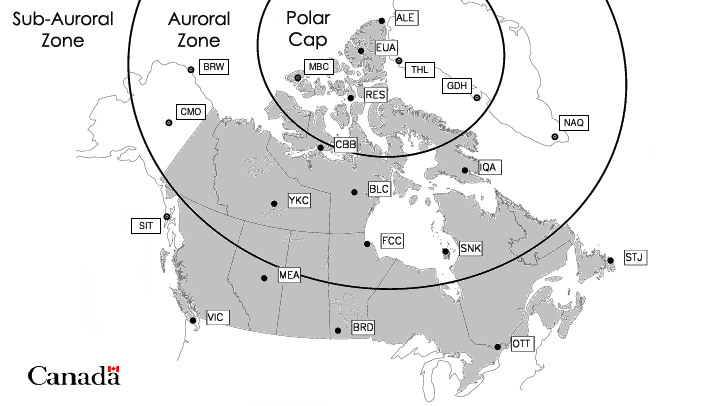

In [11]:
from IPython.display import Image
Image("/Users/gracecox/Dropbox/Talks/iaga_magpysv/figs/zonemap.png")

Rerun the analysis below for each of the three high latitude regions. Everything preceding this cell only needs to be run once.

In [105]:
# Select observatories in a particular region. 
#observatory_list = ['GDH', 'RES', 'THL'] # Polar cap
observatory_list = ['BLC', 'BRW', 'YKC'] # Auroral zone
#observatory_list = ['OTT', 'STJ', 'VIC'] # Sub-auroral zone

# Residuals

Concatenate the data for our selected observatories.

In [121]:
# Start and end dates of the analysis as (year, month, day)
start = dt.datetime(1990, 1, 1)
end = dt.datetime(2010, 12, 31)

obs_data, model_sv_data, model_mf_data = inputoutput.combine_csv_data(
    start_date=start, end_date=end, obs_list=observatory_list,
    data_path=download_dir + 'monthly_sv/admm/',
    model_path="/Users/gracecox/Dropbox/field_models/cov-obs_x1/monthly_vals/", day_of_month=15)

dates = obs_data['date']

In [107]:
obs_data

date      dX_BLC     dY_BLC      dZ_BLC     dX_BRW     dY_BRW  \
0   1980-01-15   60.106428 -25.757126  -44.491341 -21.437360  -7.615350   
1   1980-02-15   59.629032 -24.118280  -48.563172 -15.494995  -6.434563   
2   1980-03-15   50.736742 -37.932778  -50.966745 -24.072302  -9.999340   
3   1980-04-15   44.501344 -21.174731  -43.633065 -16.904302 -11.415617   
4   1980-05-15   29.295833 -28.573611  -38.063889 -22.807962 -13.067355   
5   1980-06-15   51.403226  -8.211022  -37.463996   1.235481  -3.279373   
6   1980-07-15         NaN -27.531859  -24.729924   1.501166  -3.752201   
7   1980-08-15   22.635910 -33.502514  -22.463259 -21.545872 -11.225388   
8   1980-09-15   14.359072 -18.103467  -13.593519 -42.457581 -24.749758   
9   1980-10-15   15.939181 -23.711111    1.277112 -28.734700 -30.351192   
10  1980-11-15   20.390295 -17.279191    5.526509 -28.414867 -32.901699   
11  1980-12-15   50.641608 -19.061397   -4.324323 -19.306881 -15.037710   
12  1981-01-15   25.587120 -22.836960    0.378438 -18.418389 -21.927947   
13  1981-02-15   35.681452 -35.455645   -6.573925  -8.161225 -15.030528   
14  1981-03-15   37.159173 -21.994078  -18.273498  -7.462332 -13.276767   
15  1981-04-15   22.161785 -18.731535  -12.864170 -34.687869 -19.712345   
16  1981-05-15   30.643056 -27.966667  -19.597222 -28.698504 -18.205441   
17  1981-06-15   32.233318 -39.457756  -26.775581 -28.814479 -16.136857   
18  1981-07-15   32.515964 -20.599784  -22.232442 -35.811161 -21.977448   
19  1981-08-15   16.261905  -6.364583    1.005952 -57.298592 -37.759951   
20  1981-09-15   34.869624 -16.452957  -41.895161 -17.768794 -11.960162   
21  1981-10-15   36.520542 -19.168056  -42.523611  -9.654231  -6.403143   
22  1981-11-15   27.817204 -22.944892  -40.455645 -12.450804  -6.346841   
23  1981-12-15   17.429167 -12.819444  -21.126389 -14.385609 -21.497803   
24  1982-01-15   33.243280 -31.611559  -18.141129 -29.478163 -24.760779   
25  1982-02-15   59.176075  -5.979839  -14.731183 -40.968846 -30.634560   
26  1982-03-15   15.216585 -21.766200    7.611076 -53.561073 -38.674985   
27  1982-04-15   40.515635 -27.327604  -30.329544 -11.003535 -17.273605   
28  1982-05-15   26.818056  -5.761111  -26.940278 -28.268039 -21.514919   
29  1982-06-15   10.319101  11.498079   -8.394831 -48.722527 -35.420034   
..         ...         ...        ...         ...        ...        ...   
342 2008-07-15   93.010611 -24.145156  -89.637576  22.100806 -51.305108   
343 2008-08-15  100.143247 -24.053507  -92.127210  43.580562 -40.253951   
344 2008-09-15  104.529681 -24.753890 -101.595472  40.692204 -45.568548   
345 2008-10-15   97.554793 -21.728963 -100.725756  33.668056 -57.633333   
346 2008-11-15   89.157812 -25.101551  -93.672800  10.318200 -74.339499   
347 2008-12-15   91.256586 -18.514396  -96.457941   6.972222 -69.734722   
348 2009-01-15   83.534785 -21.762403  -89.486102   2.305484 -72.672351   
349 2009-02-15   83.043931 -20.233372  -83.584623   5.915746 -76.356411   
350 2009-03-15   80.581139 -18.857297  -91.866152   9.052778 -74.586111   
351 2009-04-15   76.727286 -15.411817  -89.507512  13.580645 -73.973118   
352 2009-05-15   69.424200 -15.364395  -83.093185  -2.322222 -80.619444   
353 2009-06-15   77.398385 -14.418573  -85.983849  15.337366 -74.000000   
354 2009-07-15         NaN        NaN         NaN        NaN        NaN   
355 2009-08-15         NaN        NaN         NaN        NaN        NaN   
356 2009-09-15         NaN        NaN         NaN        NaN        NaN   
357 2009-10-15         NaN        NaN         NaN        NaN        NaN   
358 2009-11-15         NaN        NaN         NaN        NaN        NaN   
359 2009-12-15         NaN        NaN         NaN        NaN        NaN   
360 2010-01-15         NaN        NaN         NaN        NaN        NaN   
361 2010-02-15         NaN        NaN         NaN        NaN        NaN   
362 2010-03-15         NaN        NaN         NaN        NaN        NaN   
363 2010-04-15         NaN        N

# SV plots

<IPython.core.display.Javascript object>


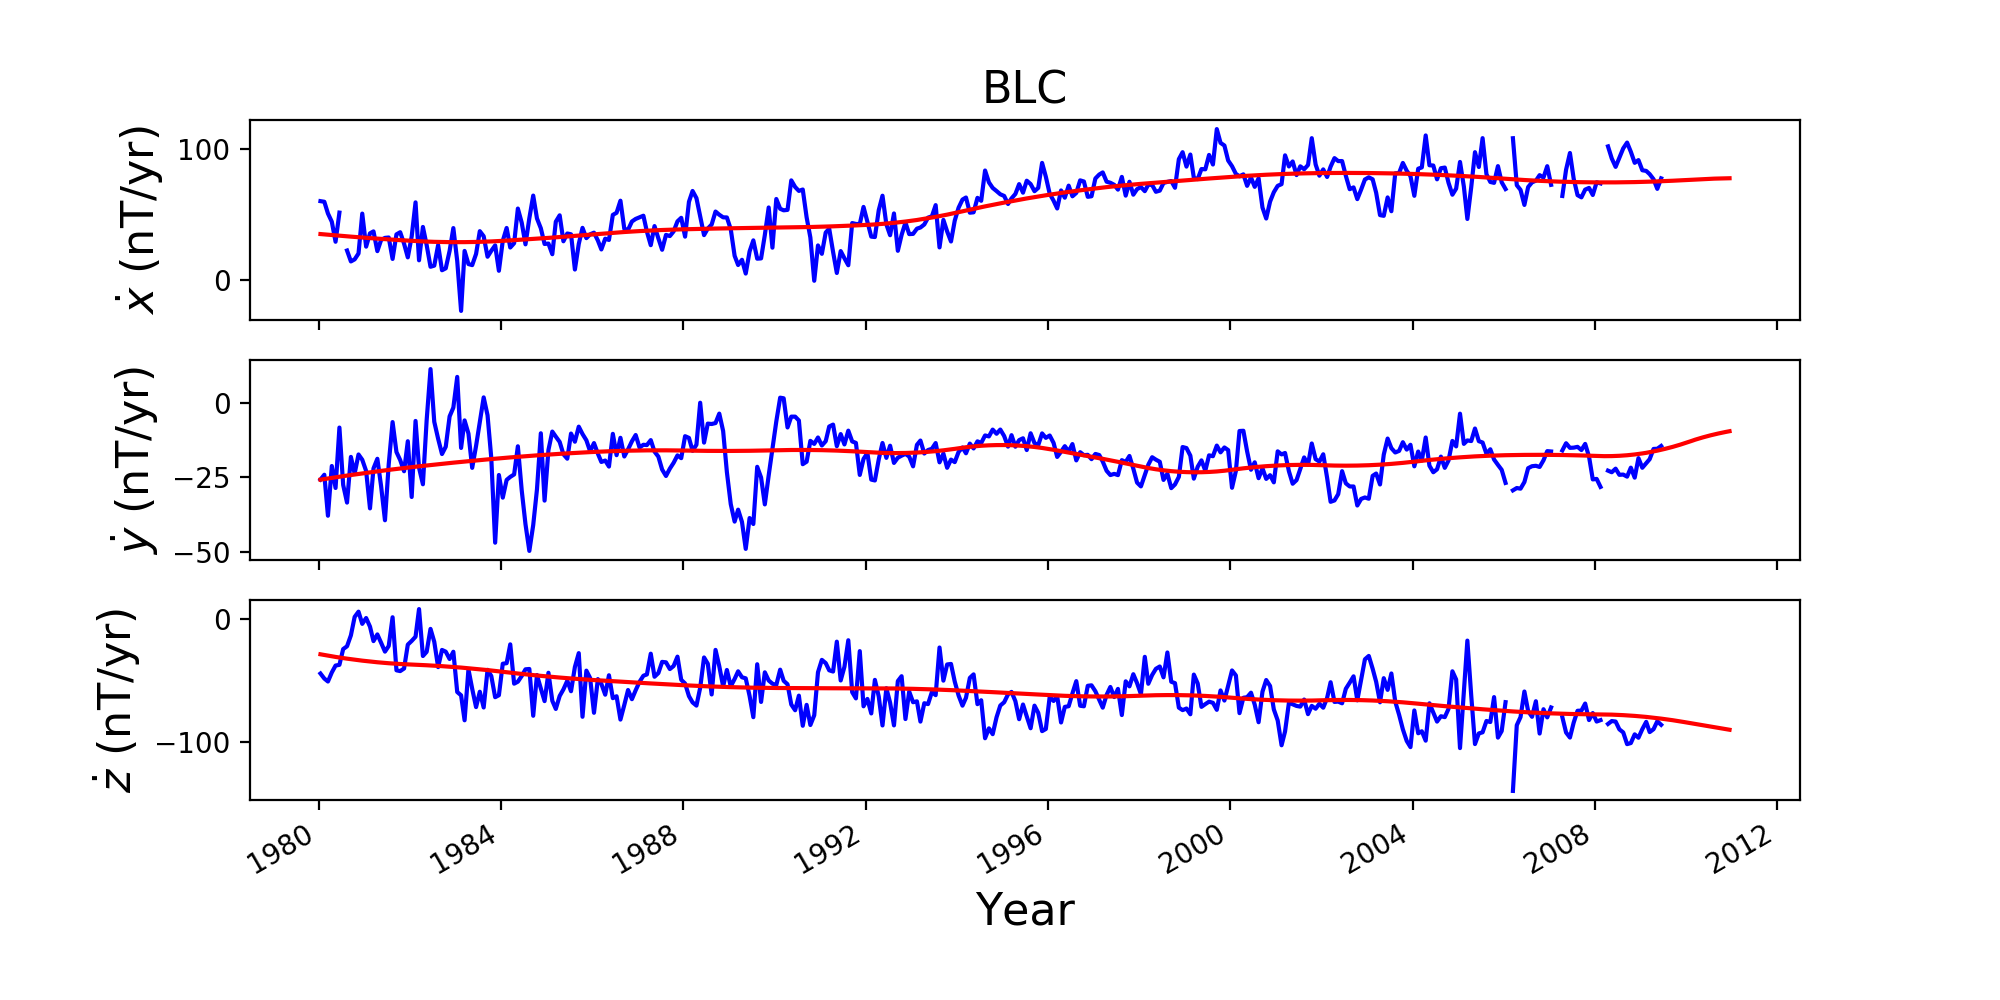

<IPython.core.display.Javascript object>


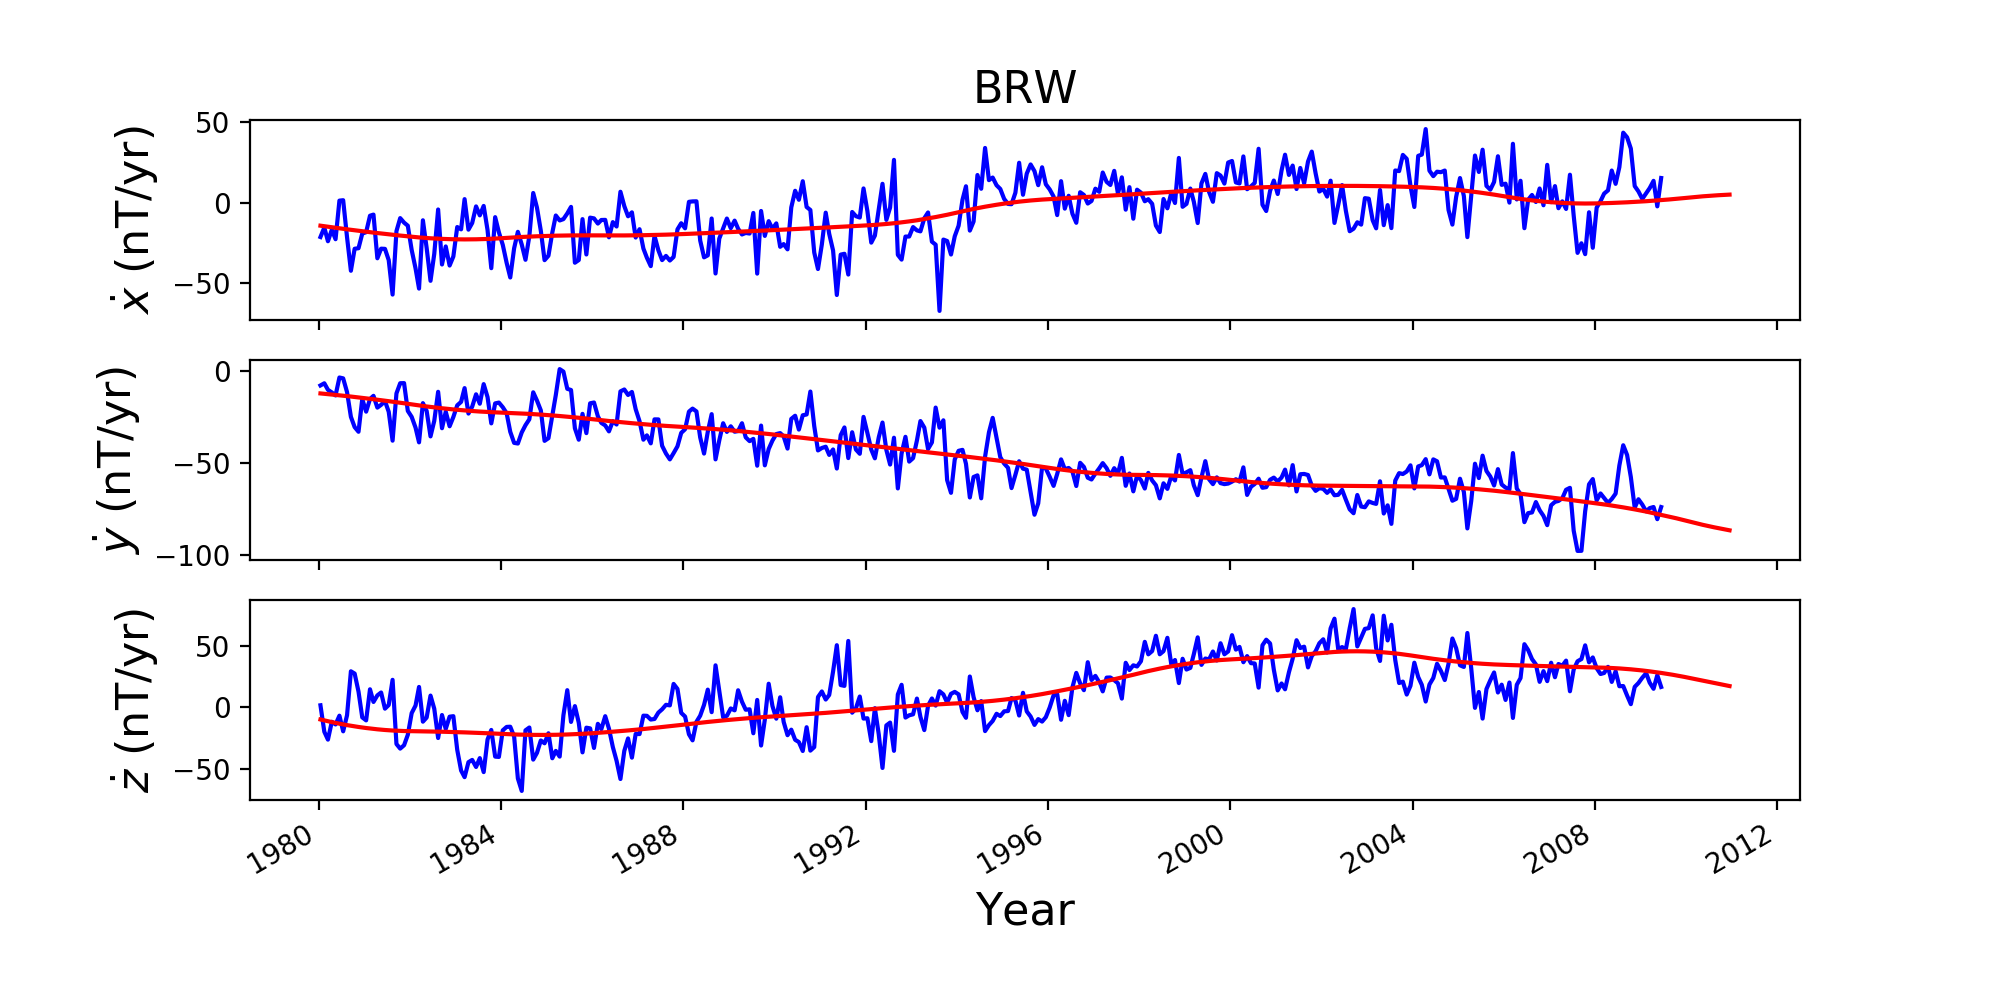

<IPython.core.display.Javascript object>


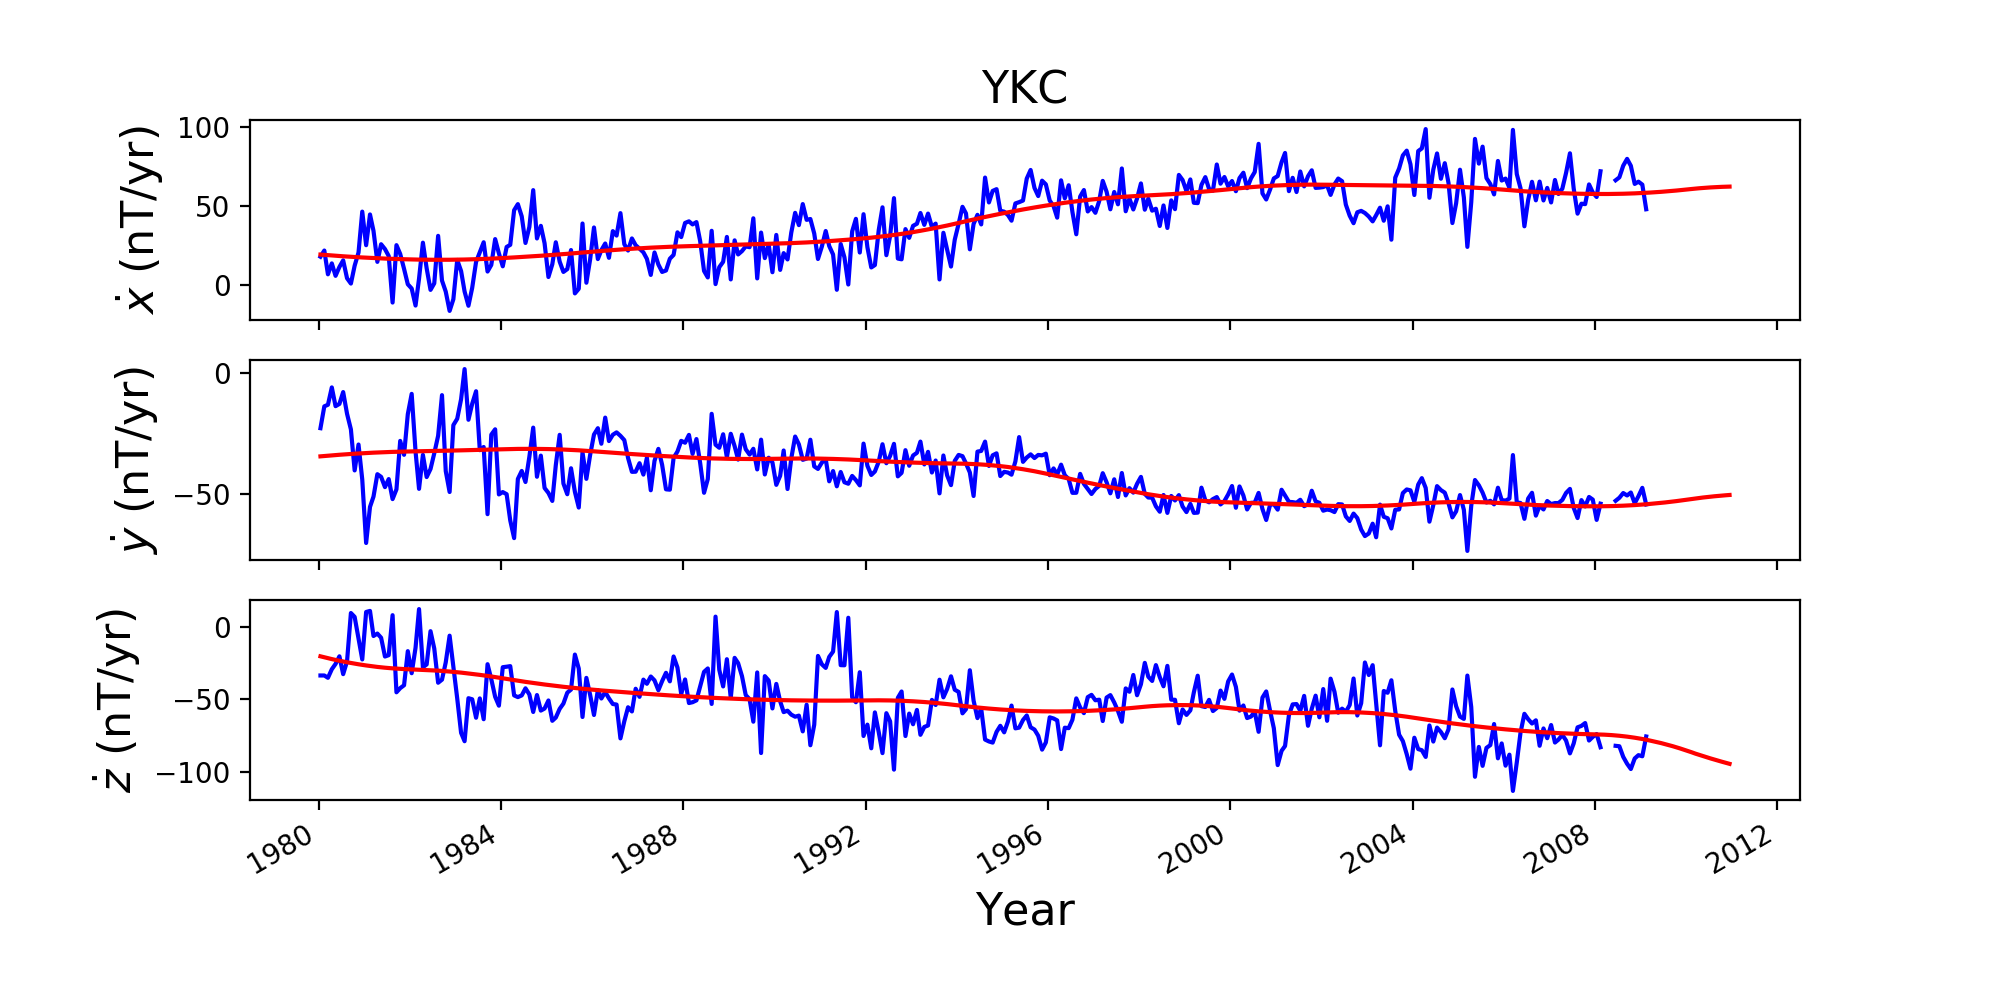

In [108]:
for observatory in observatory_list:
    fig = svplots.plot_sv(dates=dates, sv=obs_data.filter(regex=observatory),
                    model=model_sv_data.filter(regex=observatory),
                    fig_size=(10, 5), font_size=10, label_size=16, plot_legend=False,
                    obs=observatory, model_name='COV-OBS')

# Outlier detection

Optionally remove spikes in the data before denoising. Large outliers can affect the denoising process so better to remove them beforehand for some series (i.e. at high latitude observatories).

<IPython.core.display.Javascript object>


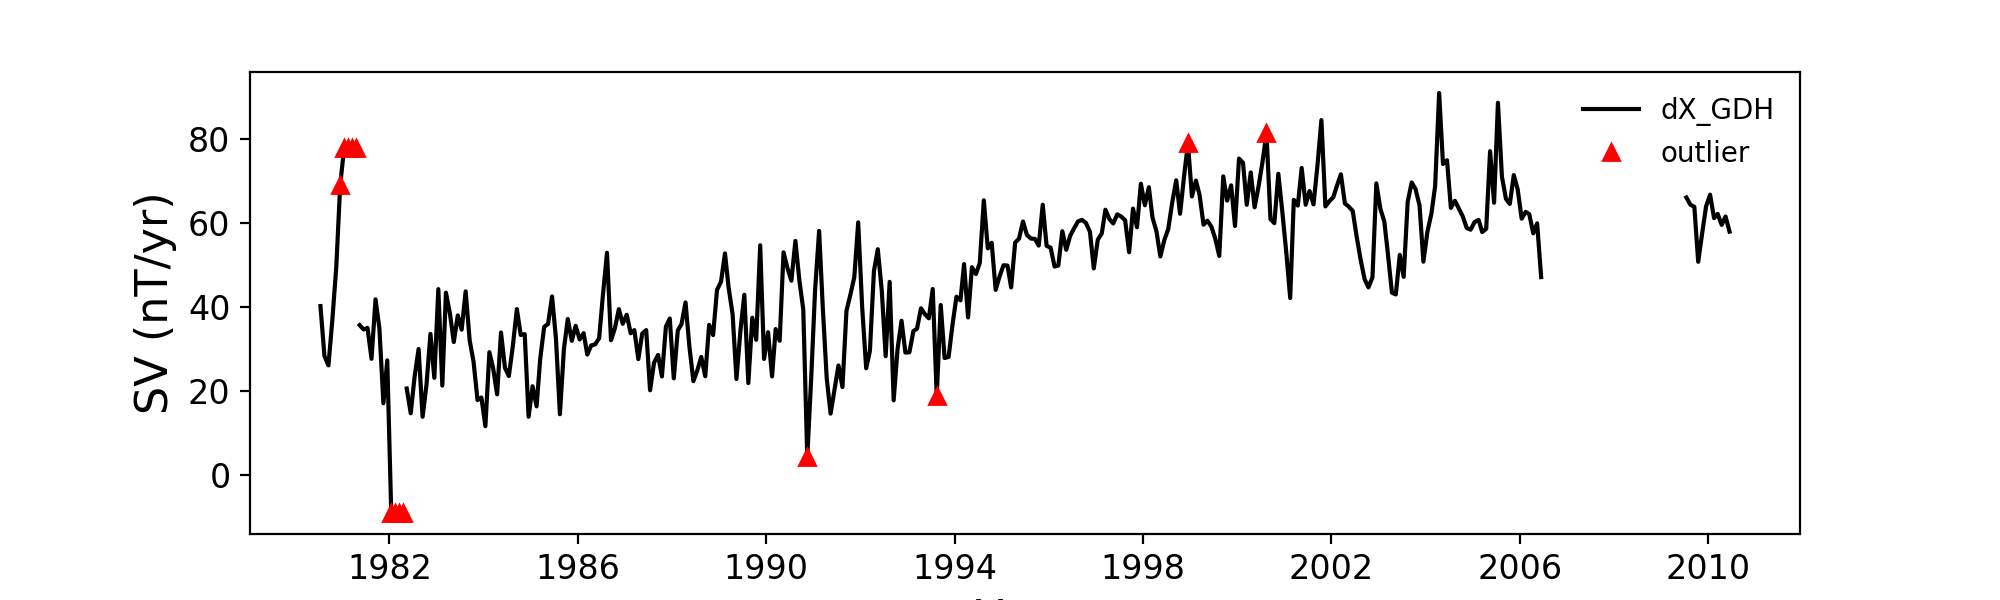

<IPython.core.display.Javascript object>


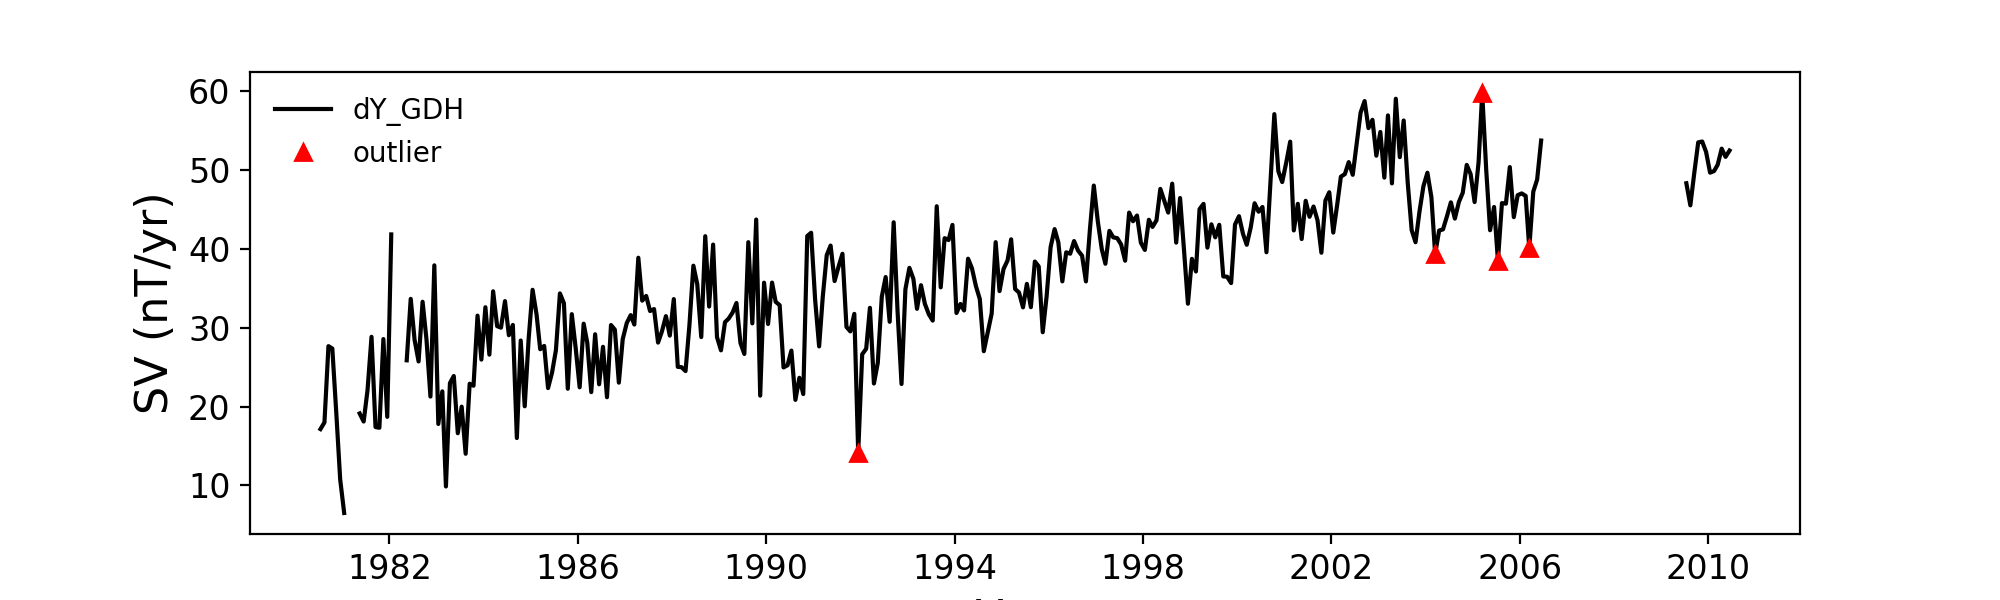

<IPython.core.display.Javascript object>


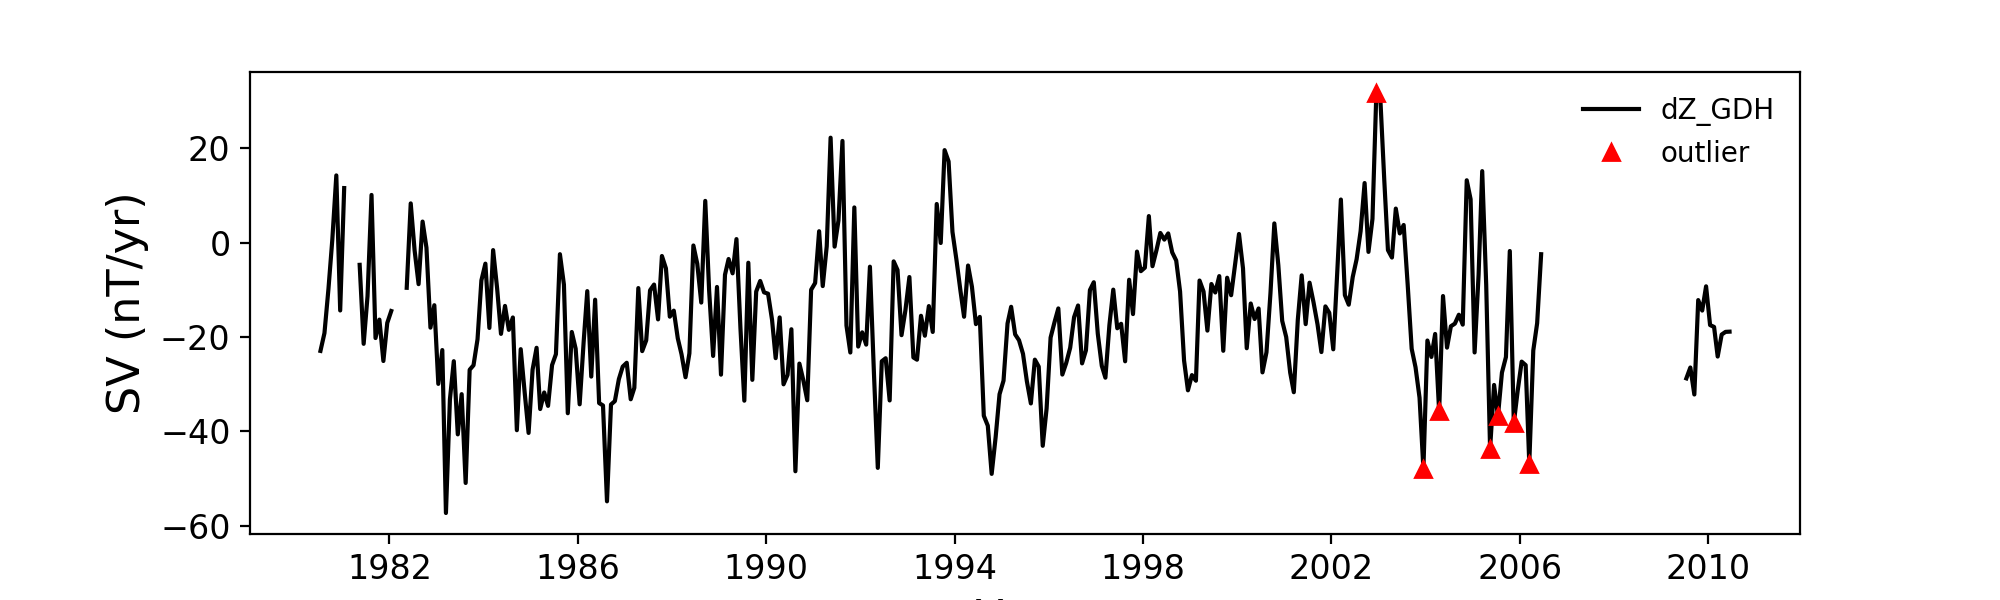

<IPython.core.display.Javascript object>


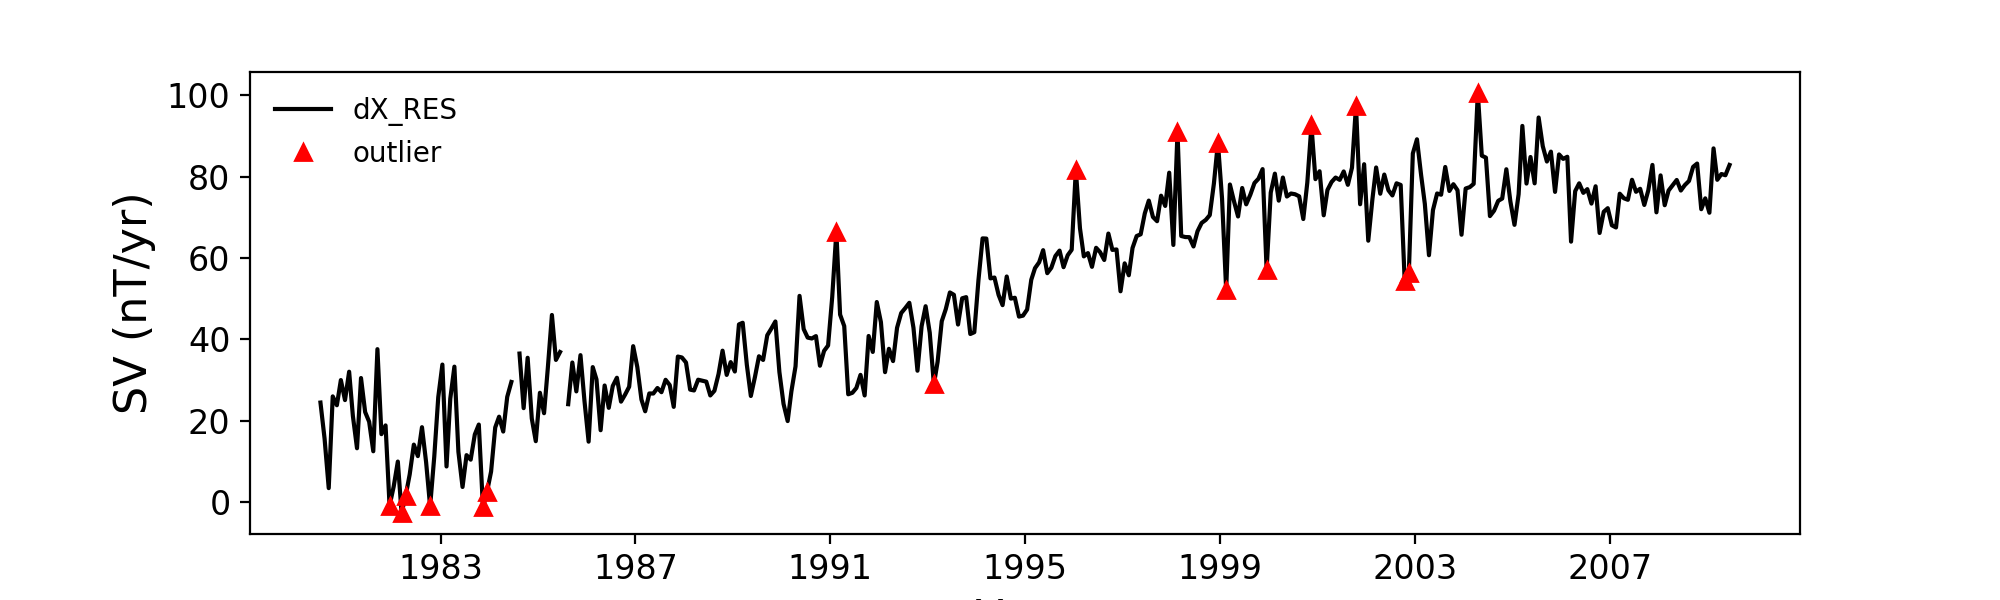

<IPython.core.display.Javascript object>


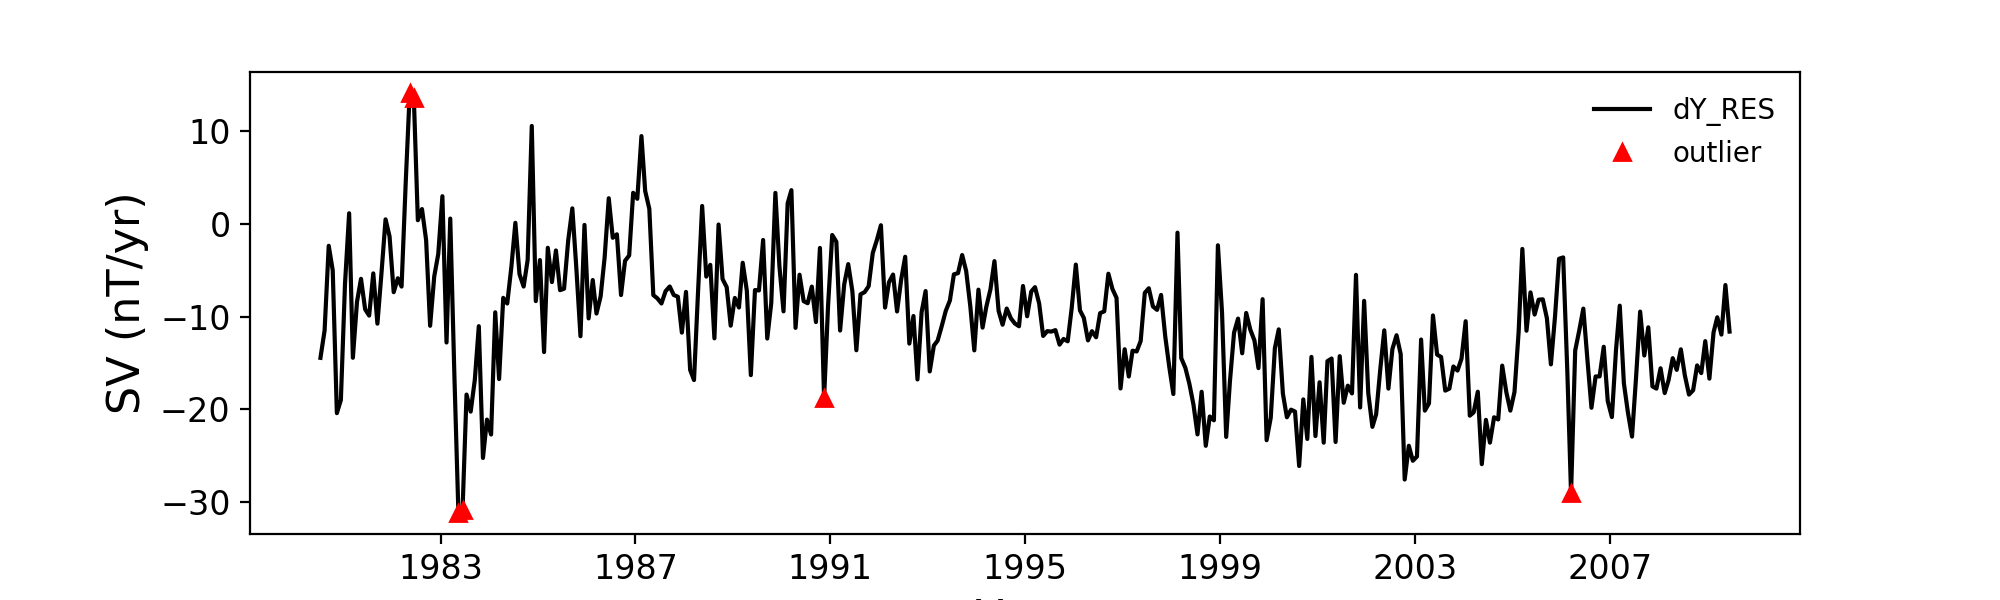

<IPython.core.display.Javascript object>


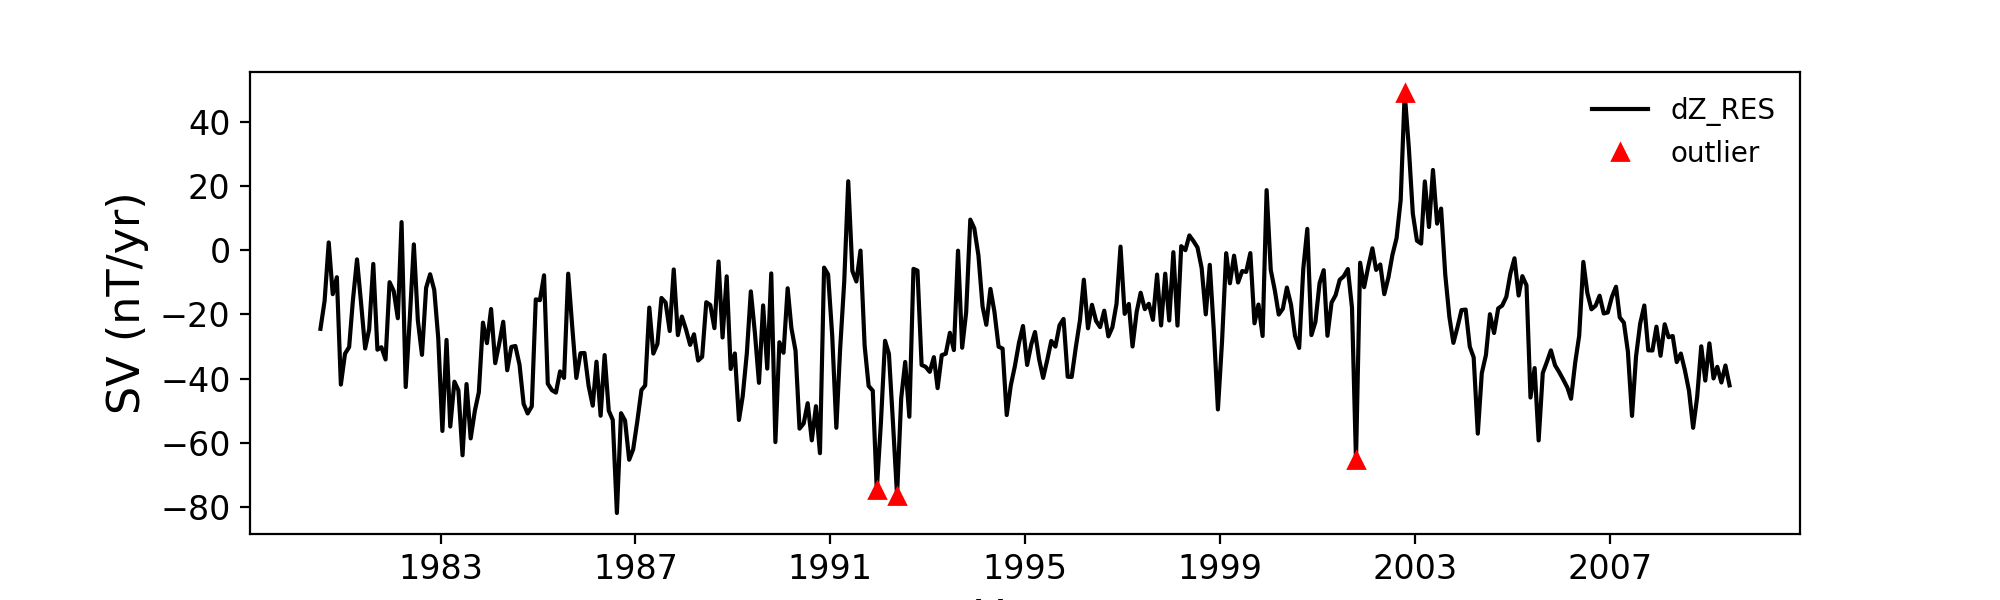

<IPython.core.display.Javascript object>


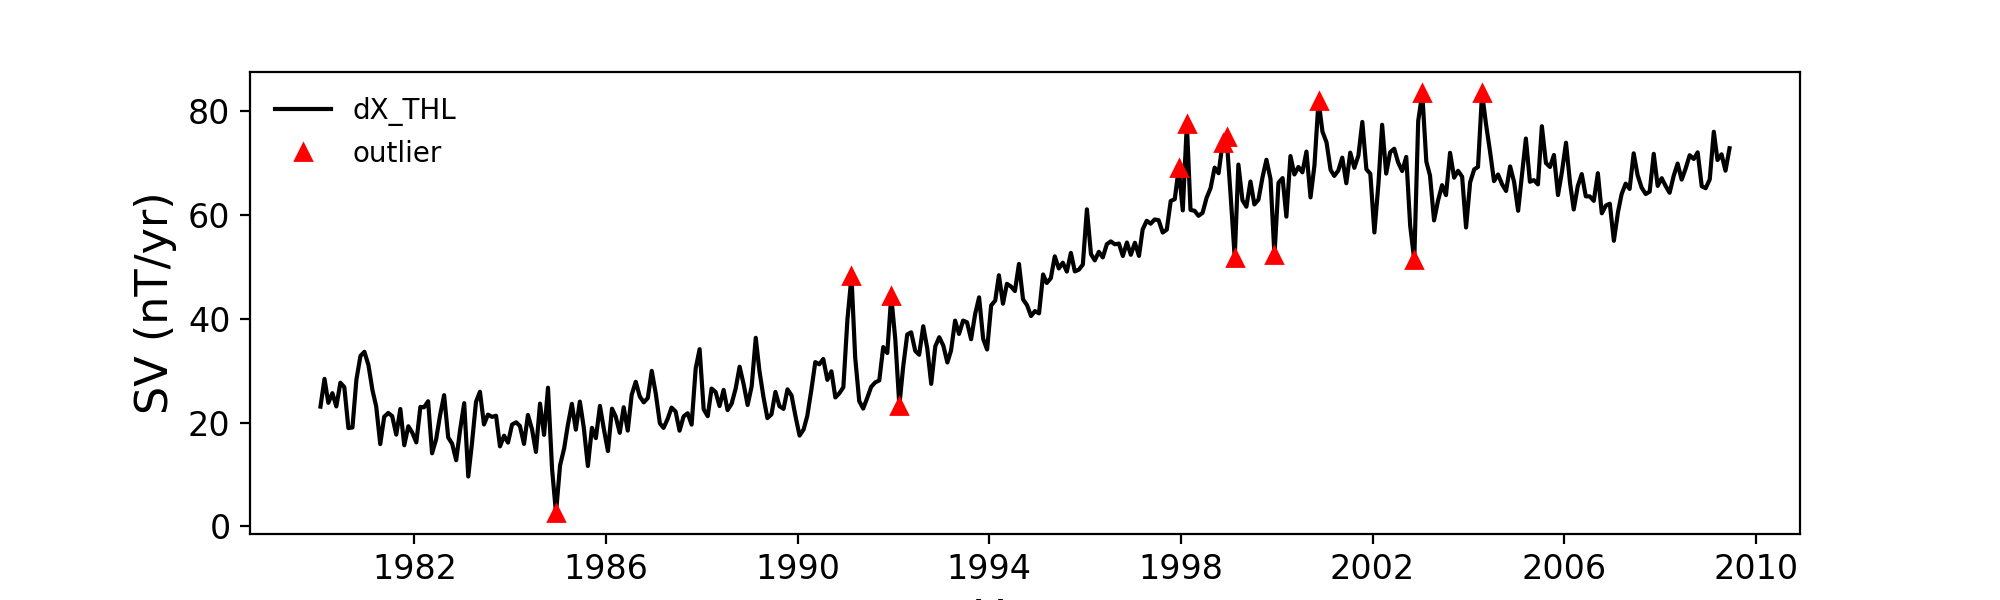

<IPython.core.display.Javascript object>


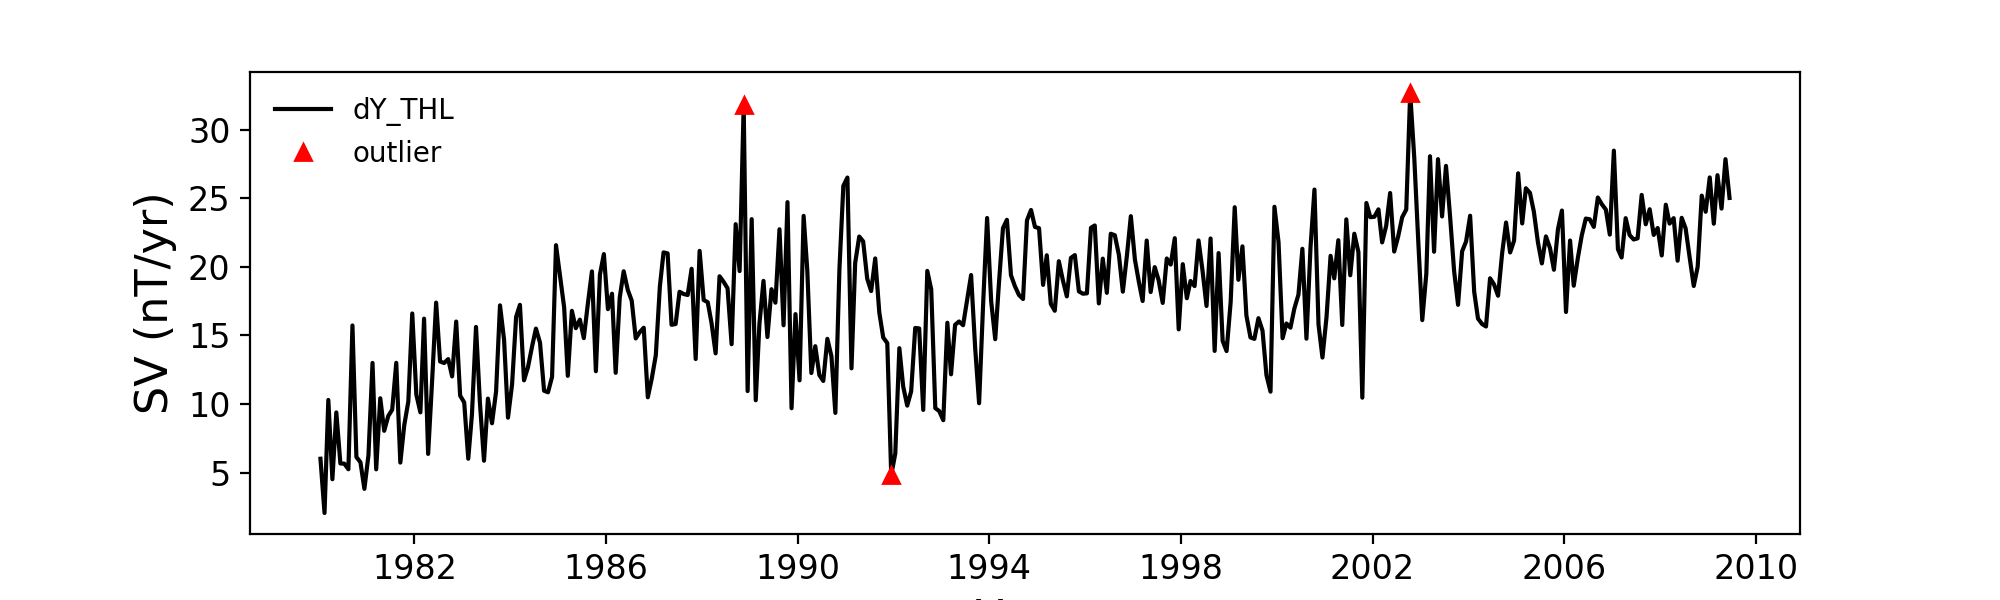

<IPython.core.display.Javascript object>


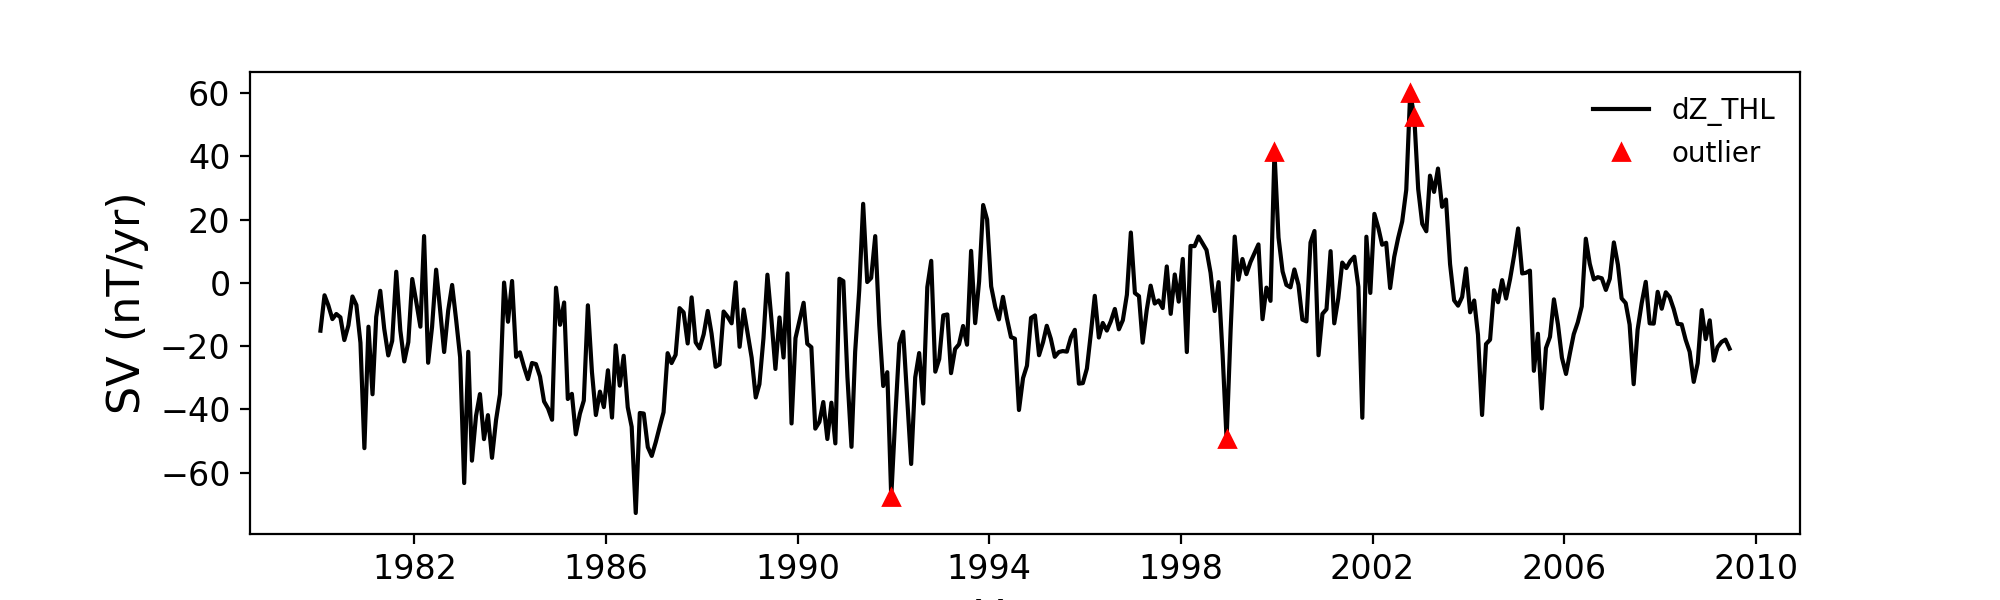

In [82]:
obs_data.drop(['date'], axis=1, inplace=True)
for column in obs_data:    
    obs_data[column] = denoise.detect_outliers(dates=dates, signal=obs_data[column], obs_name=column,
                                               threshold=3,
                                               window_length=120, plot_fig=True, fig_size=(10,3))
obs_data.insert(0, 'date', dates)

# External noise removal

Compute the residuals and use the eigenvalues/vectors of the covariance matrix to remove unmodelled external signal (Wardinski & Holme, 2011)

In [122]:
residuals = svtools.calculate_residuals(obs_data=obs_data, model_data=model_sv_data)

In [123]:
model_sv_data.drop(['date'], axis=1, inplace=True)
obs_data.drop(['date'], axis=1, inplace=True)

In [124]:
denoised, proxy, eigenvals, eigenvecs, projected_residuals, corrected_residuals = denoise.eigenvalue_analysis(
    dates=dates, obs_data=obs_data, model_data=model_sv_data, residuals=residuals,
    proxy_number=2)

/Users/gracecox/anaconda/envs/py35/lib/python3.5/site-packages/pandas/types/cast.py:537: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype)


# Denoised SV plots

Plots showing the original SV data, the denoised data (optionally with a running average) and the field model predictions.

/Users/gracecox/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


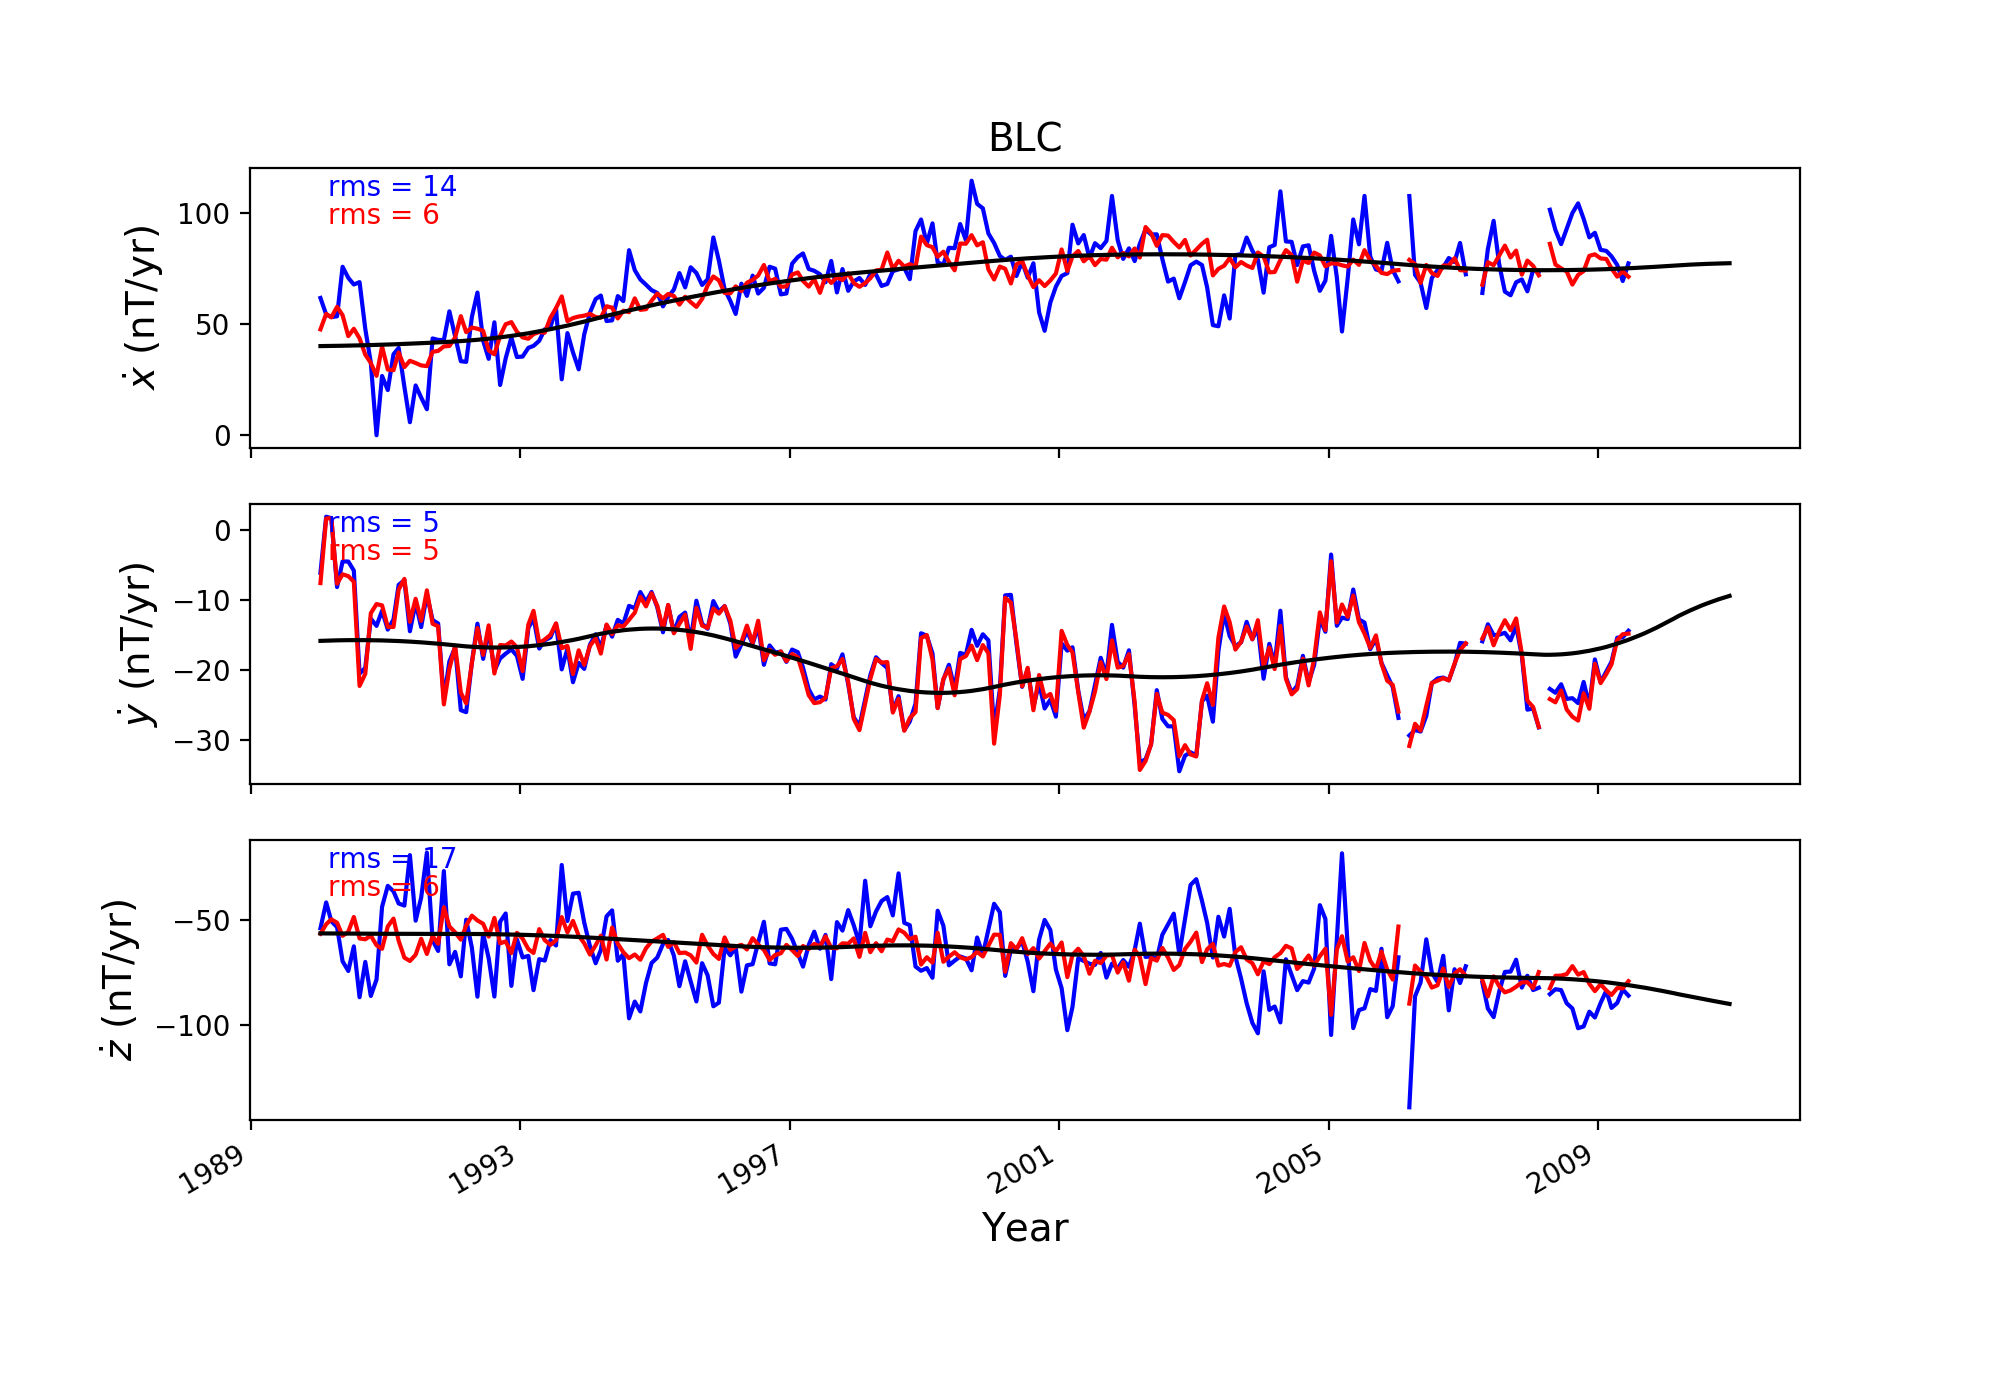

/Users/gracecox/anaconda/envs/py35/lib/python3.5/site-packages/numpy/core/numeric.py:531: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


<IPython.core.display.Javascript object>


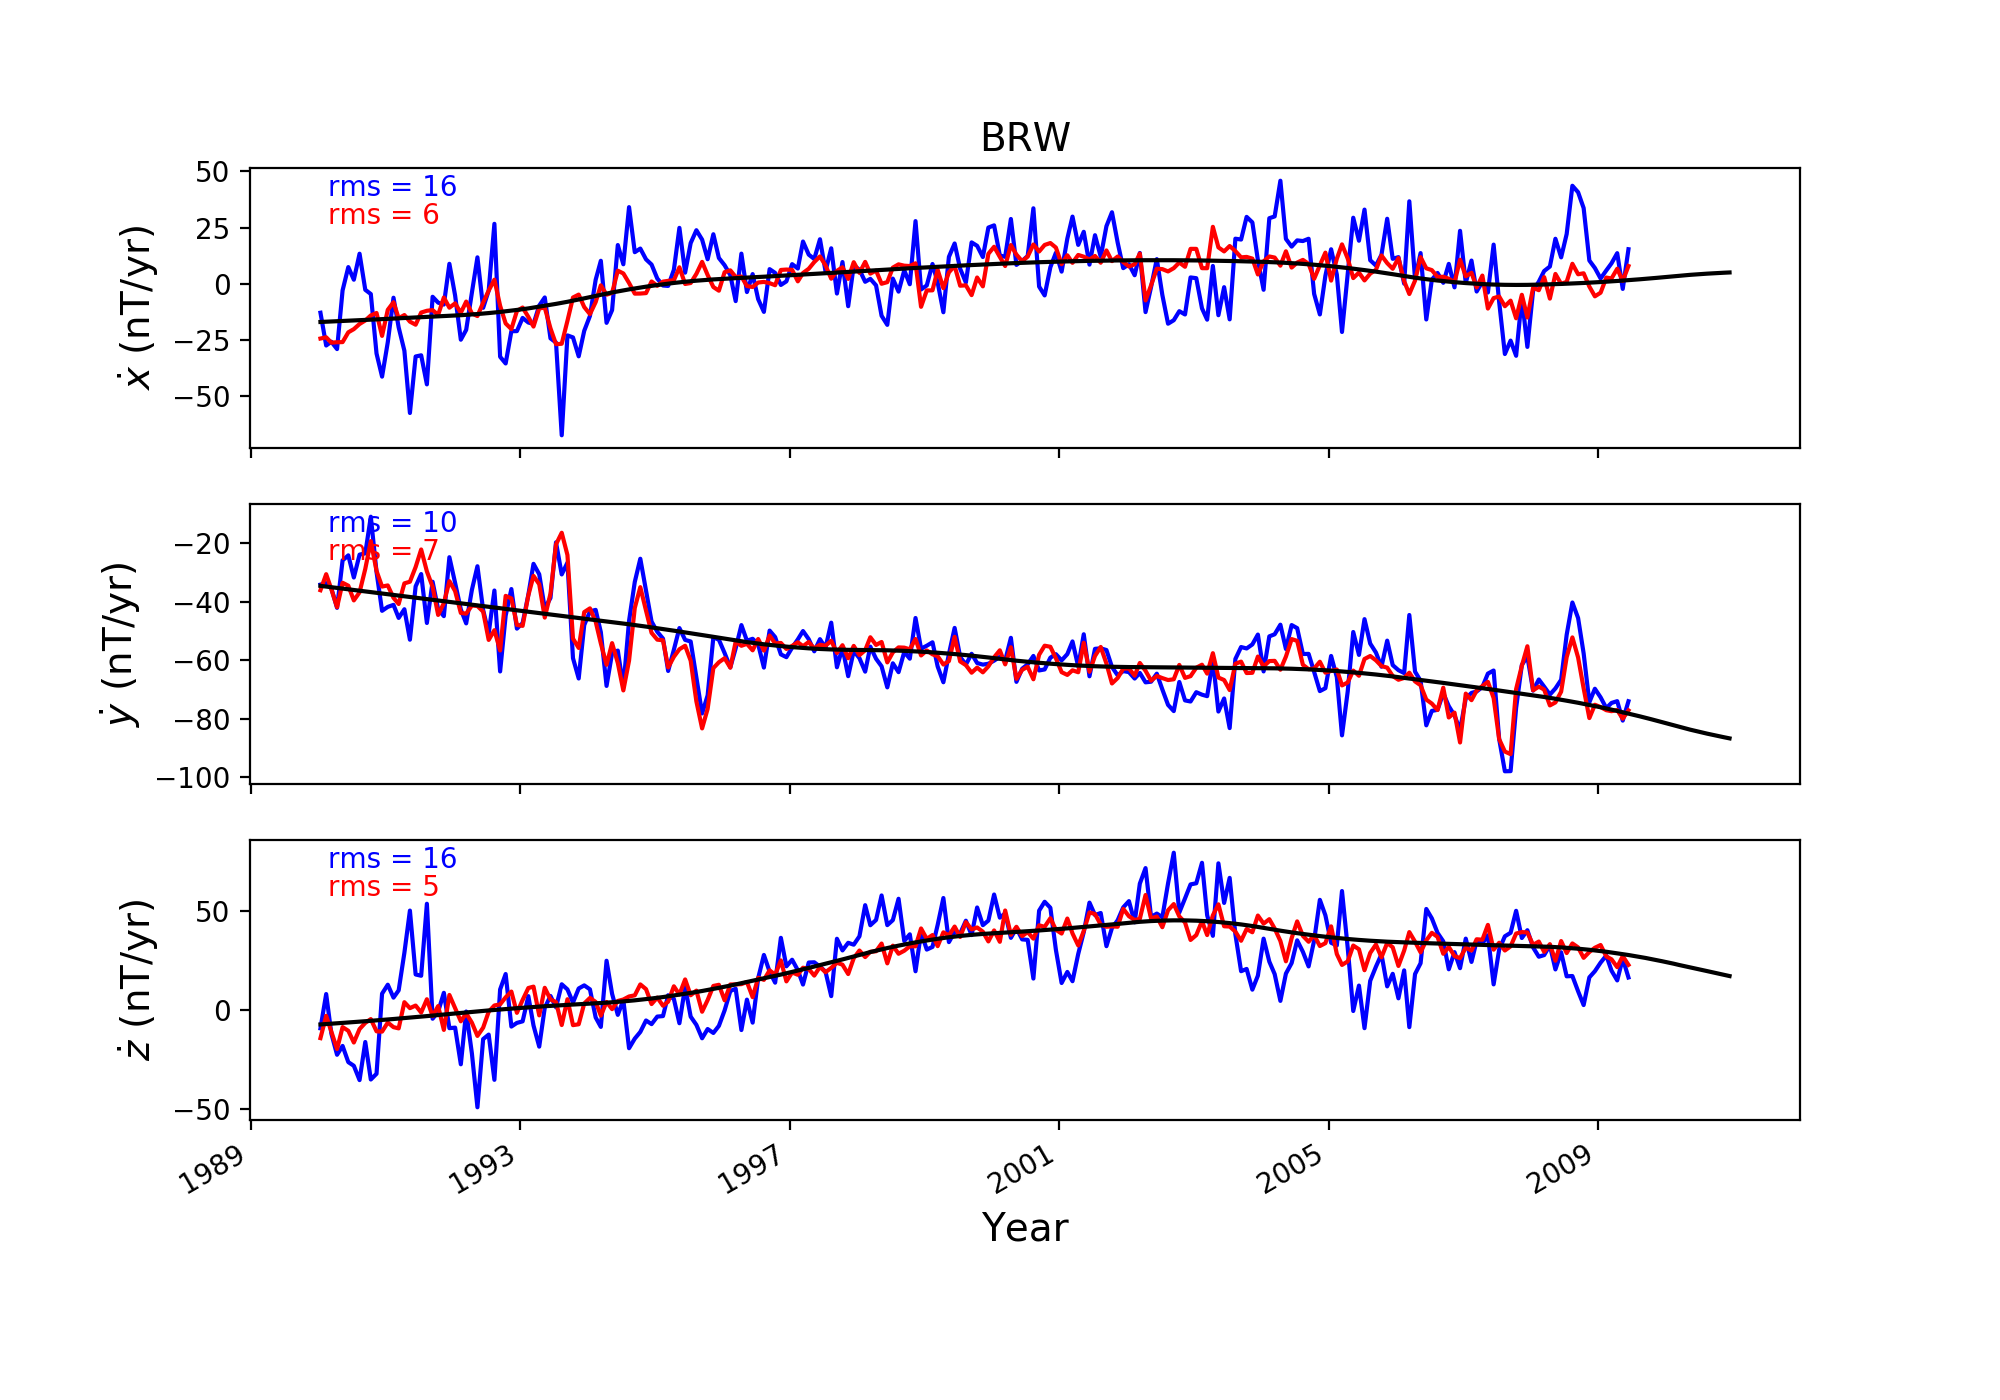

<IPython.core.display.Javascript object>


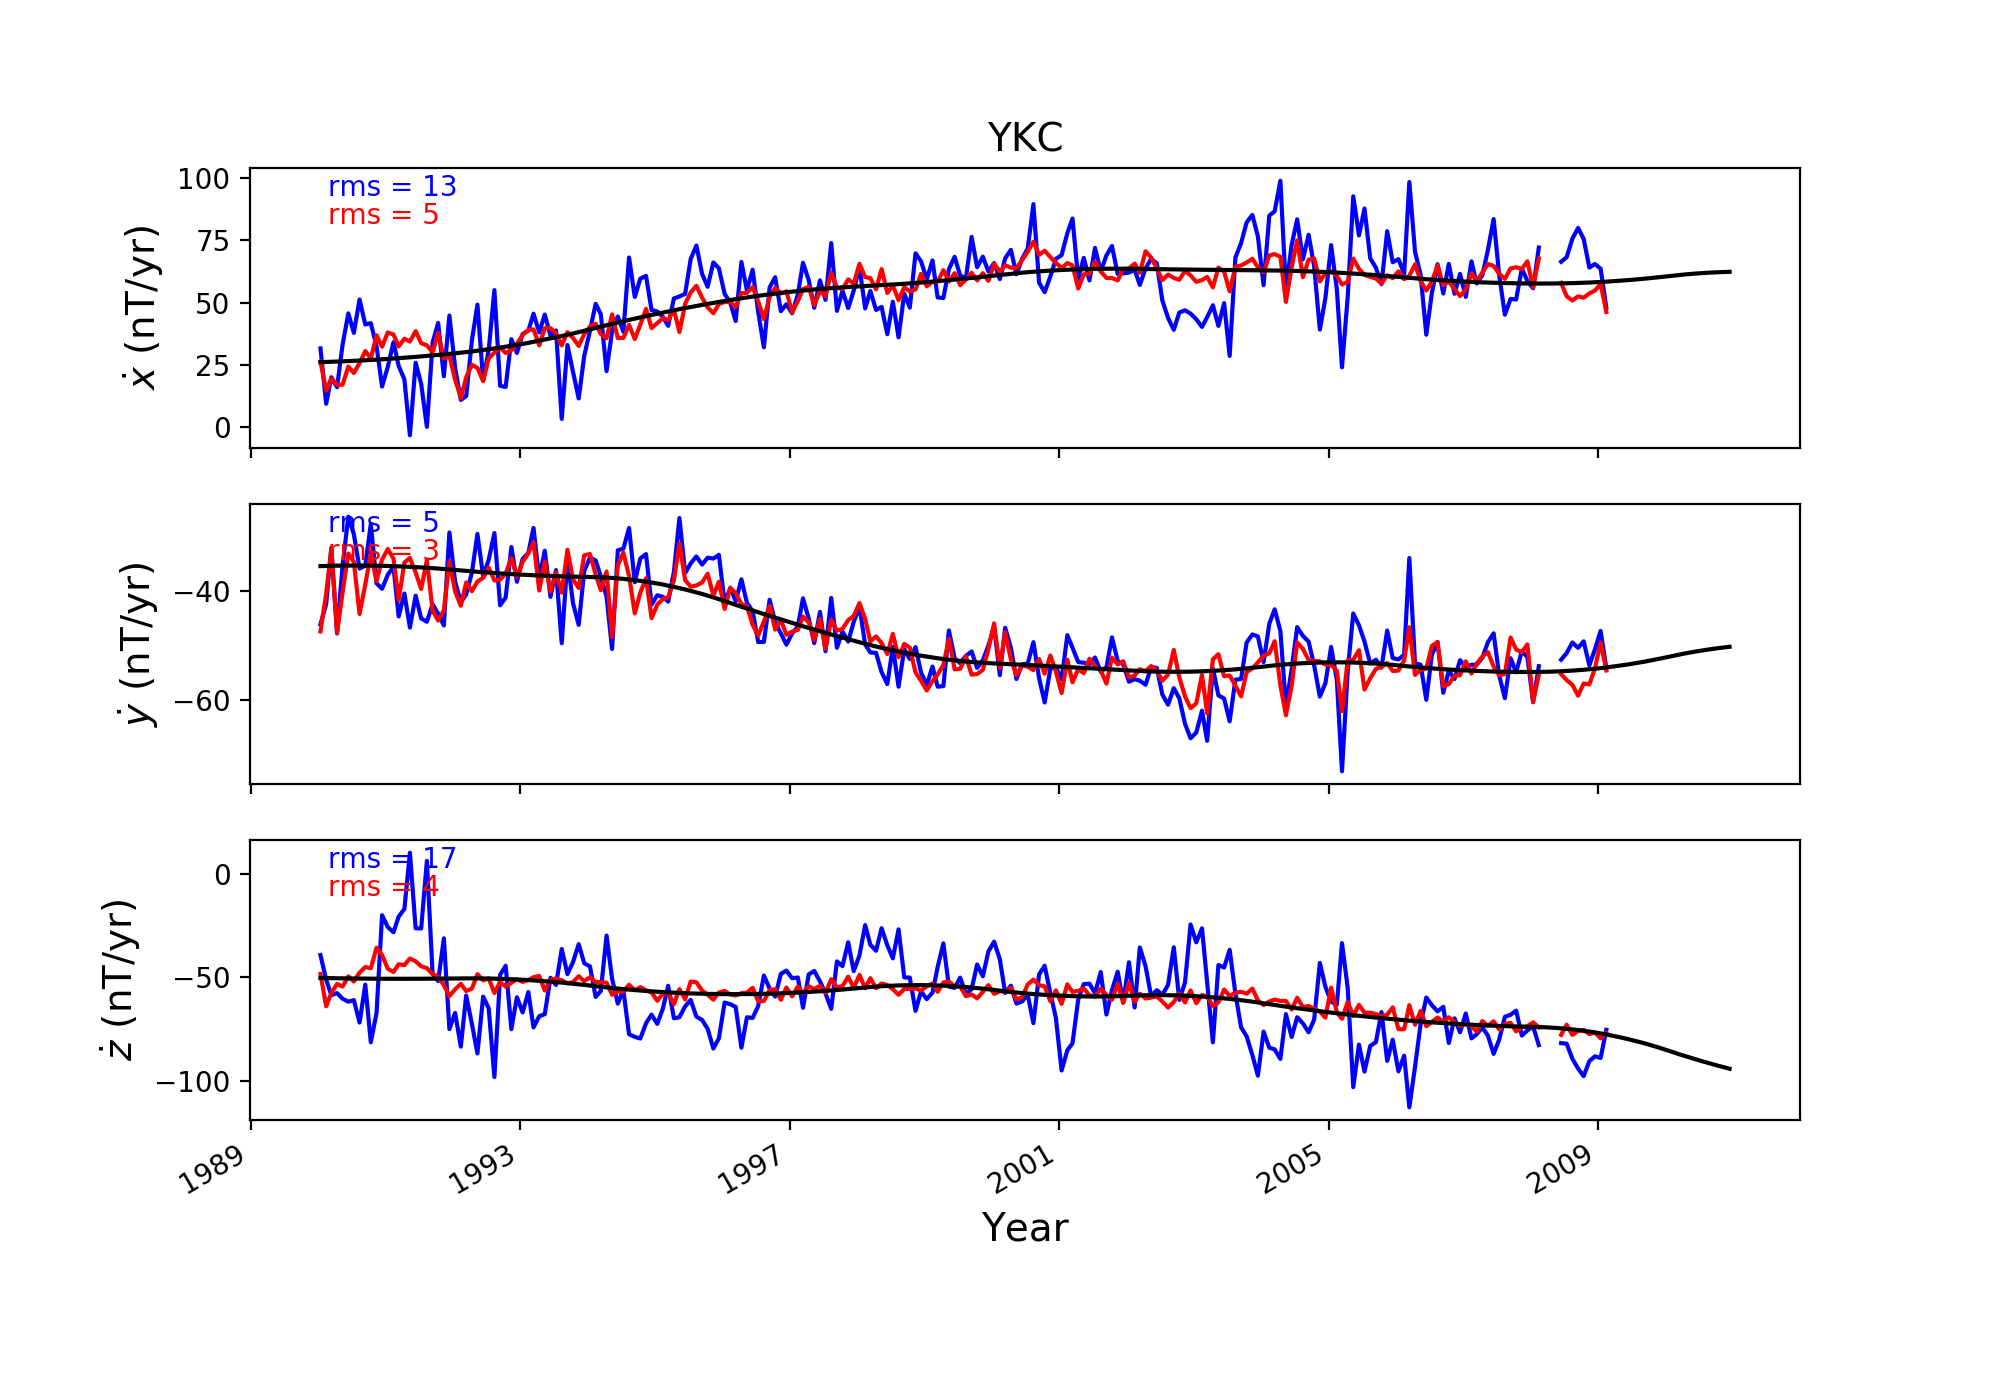

In [125]:
for observatory in observatory_list:
    xratio, yratio, zratio = svplots.plot_sv_comparison(dates=dates, denoised_sv=denoised.filter(regex=observatory),
        residuals=residuals.filter(regex=observatory),
        corrected_residuals = corrected_residuals.filter(regex=observatory),
        noisy_sv=obs_data.filter(regex=observatory), model=model_sv_data.filter(regex=observatory),
        model_name='COV-OBS',
        fig_size=(10, 7), font_size=10, label_size=14, obs=observatory, plot_rms=True)

Plots showing the denoised data (optionally with a running average) and the field model predictions.

/Users/gracecox/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


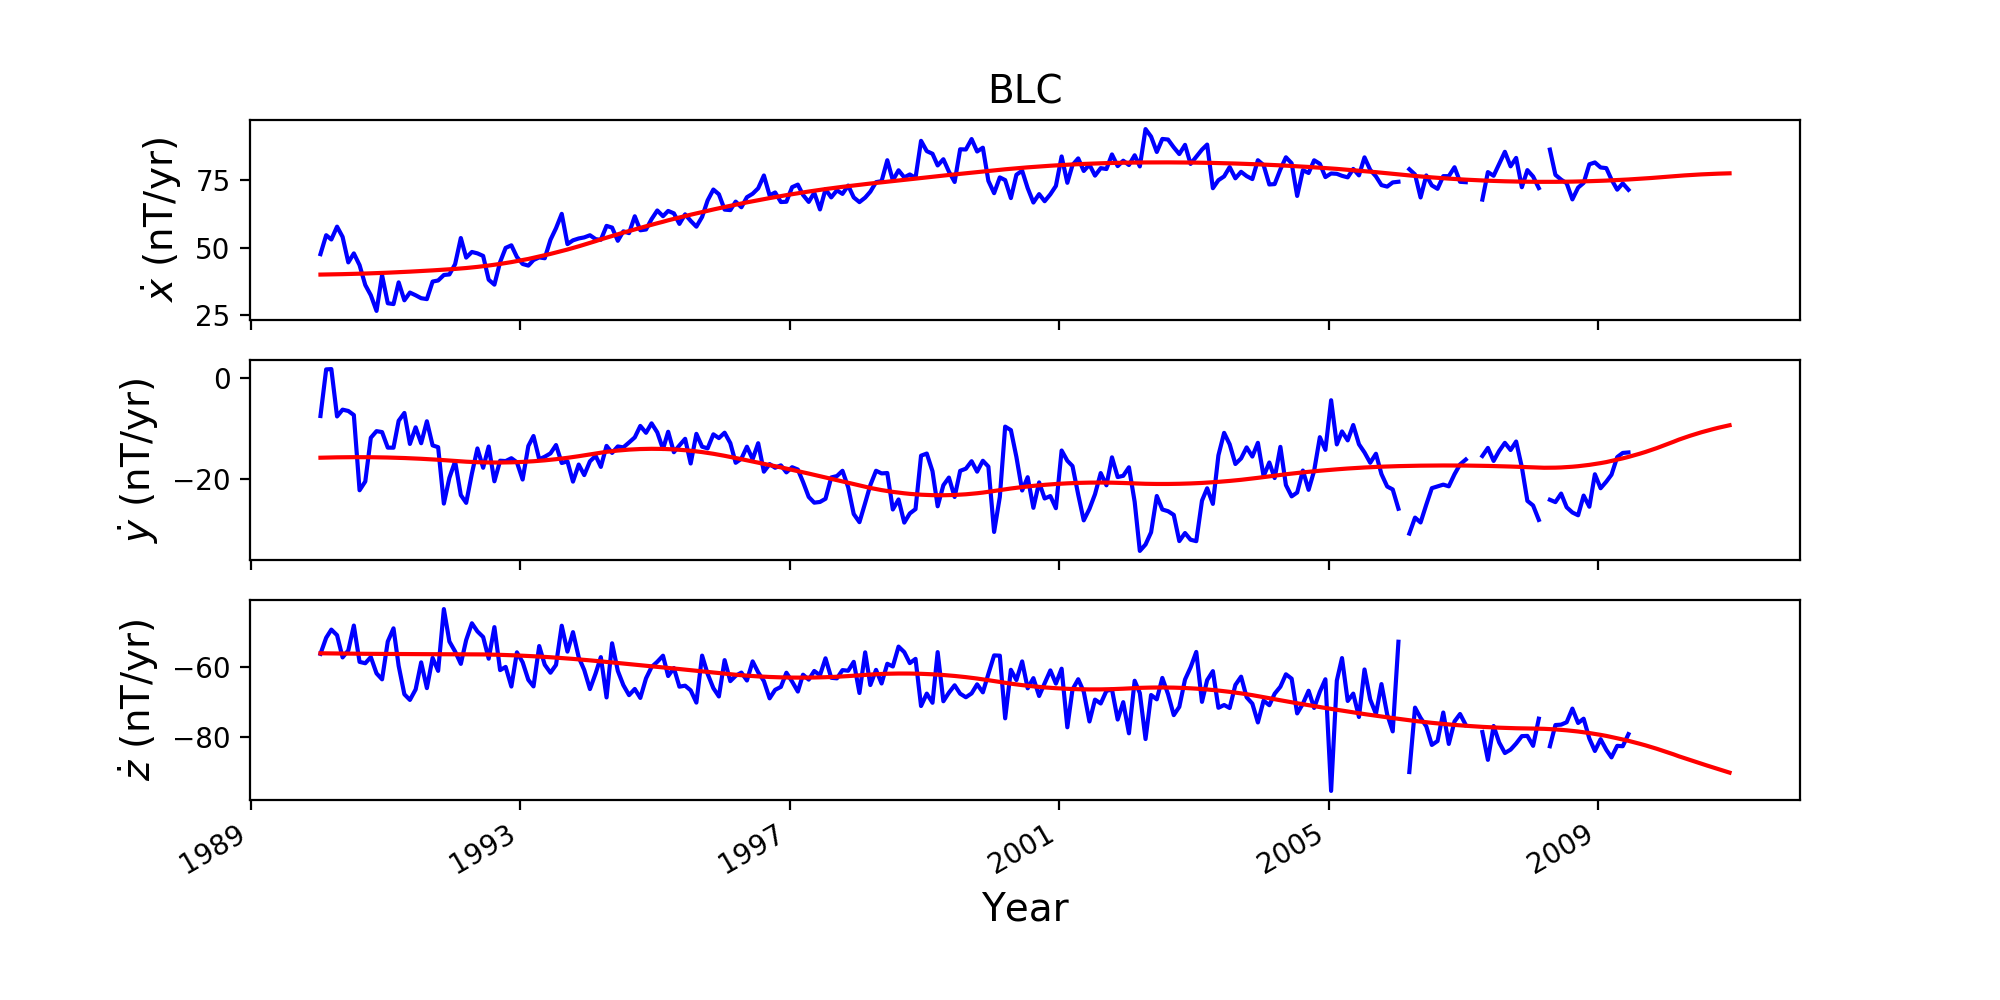

/Users/gracecox/anaconda/envs/py35/lib/python3.5/site-packages/numpy/core/numeric.py:531: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


<IPython.core.display.Javascript object>


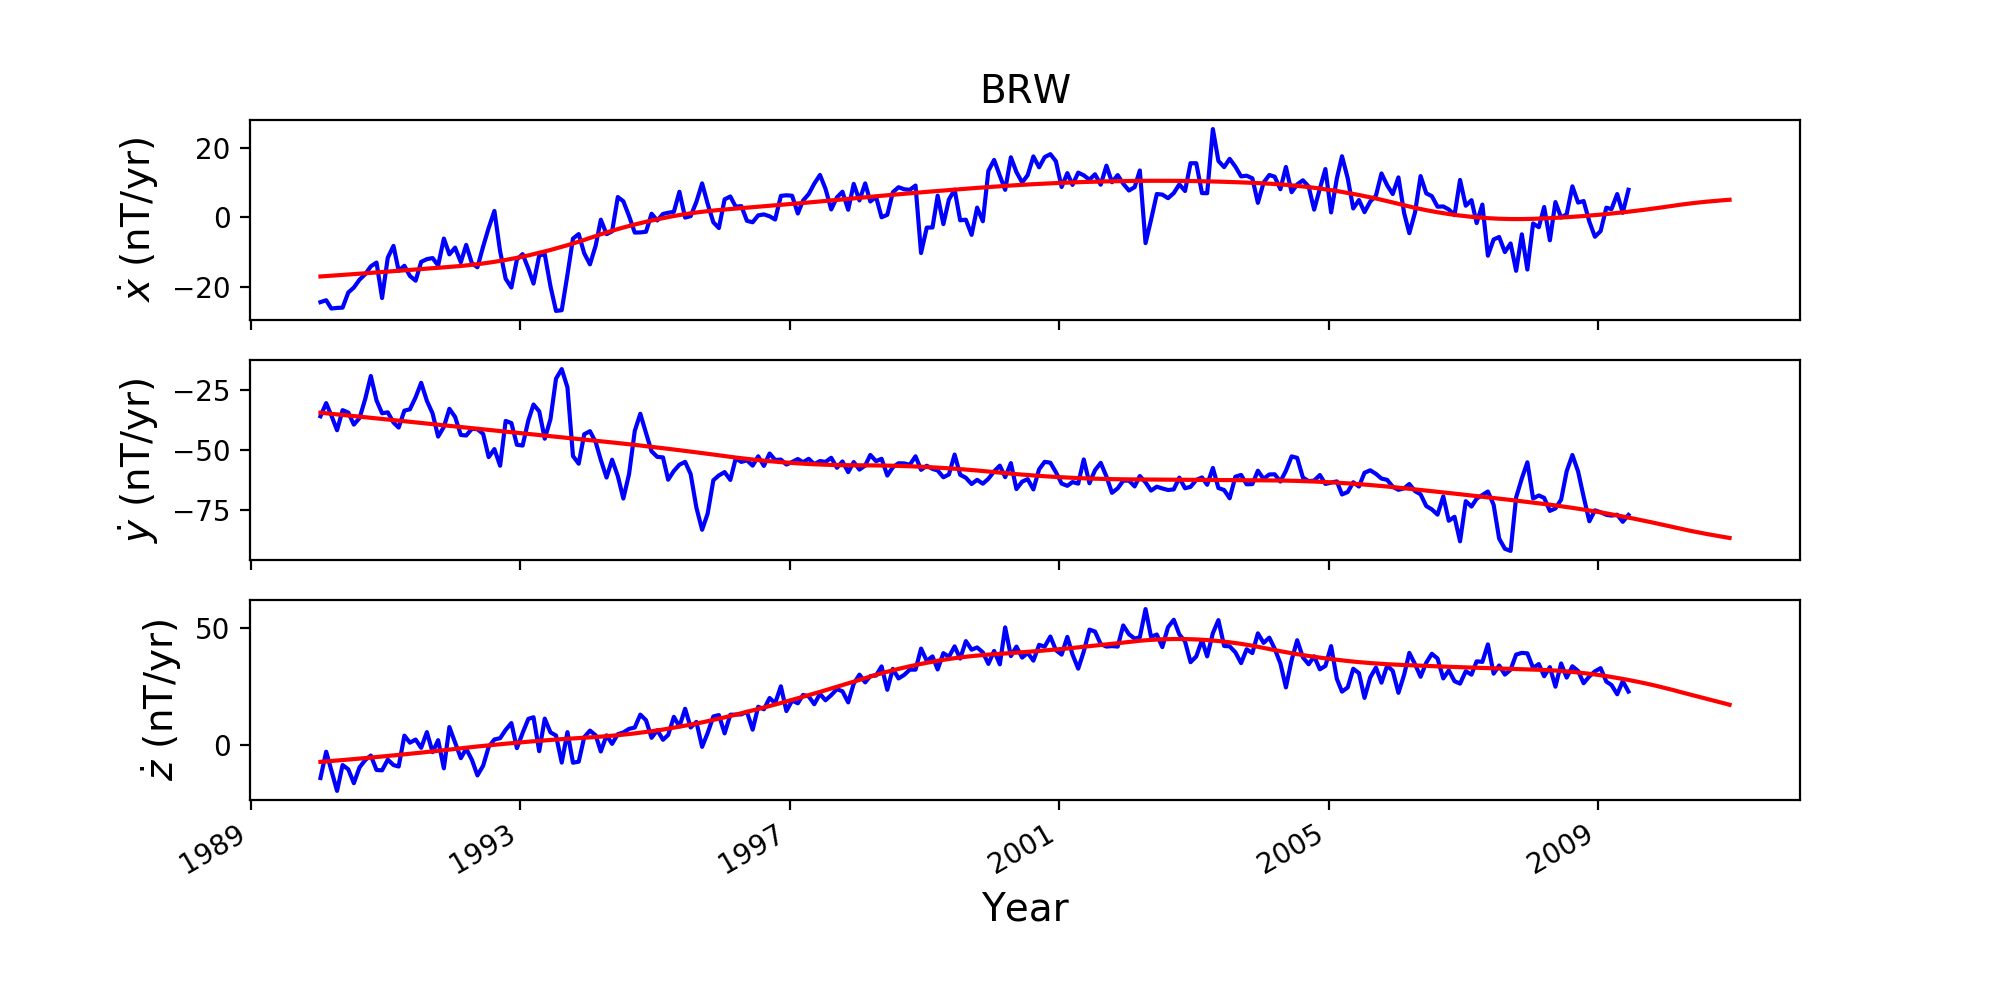

<IPython.core.display.Javascript object>


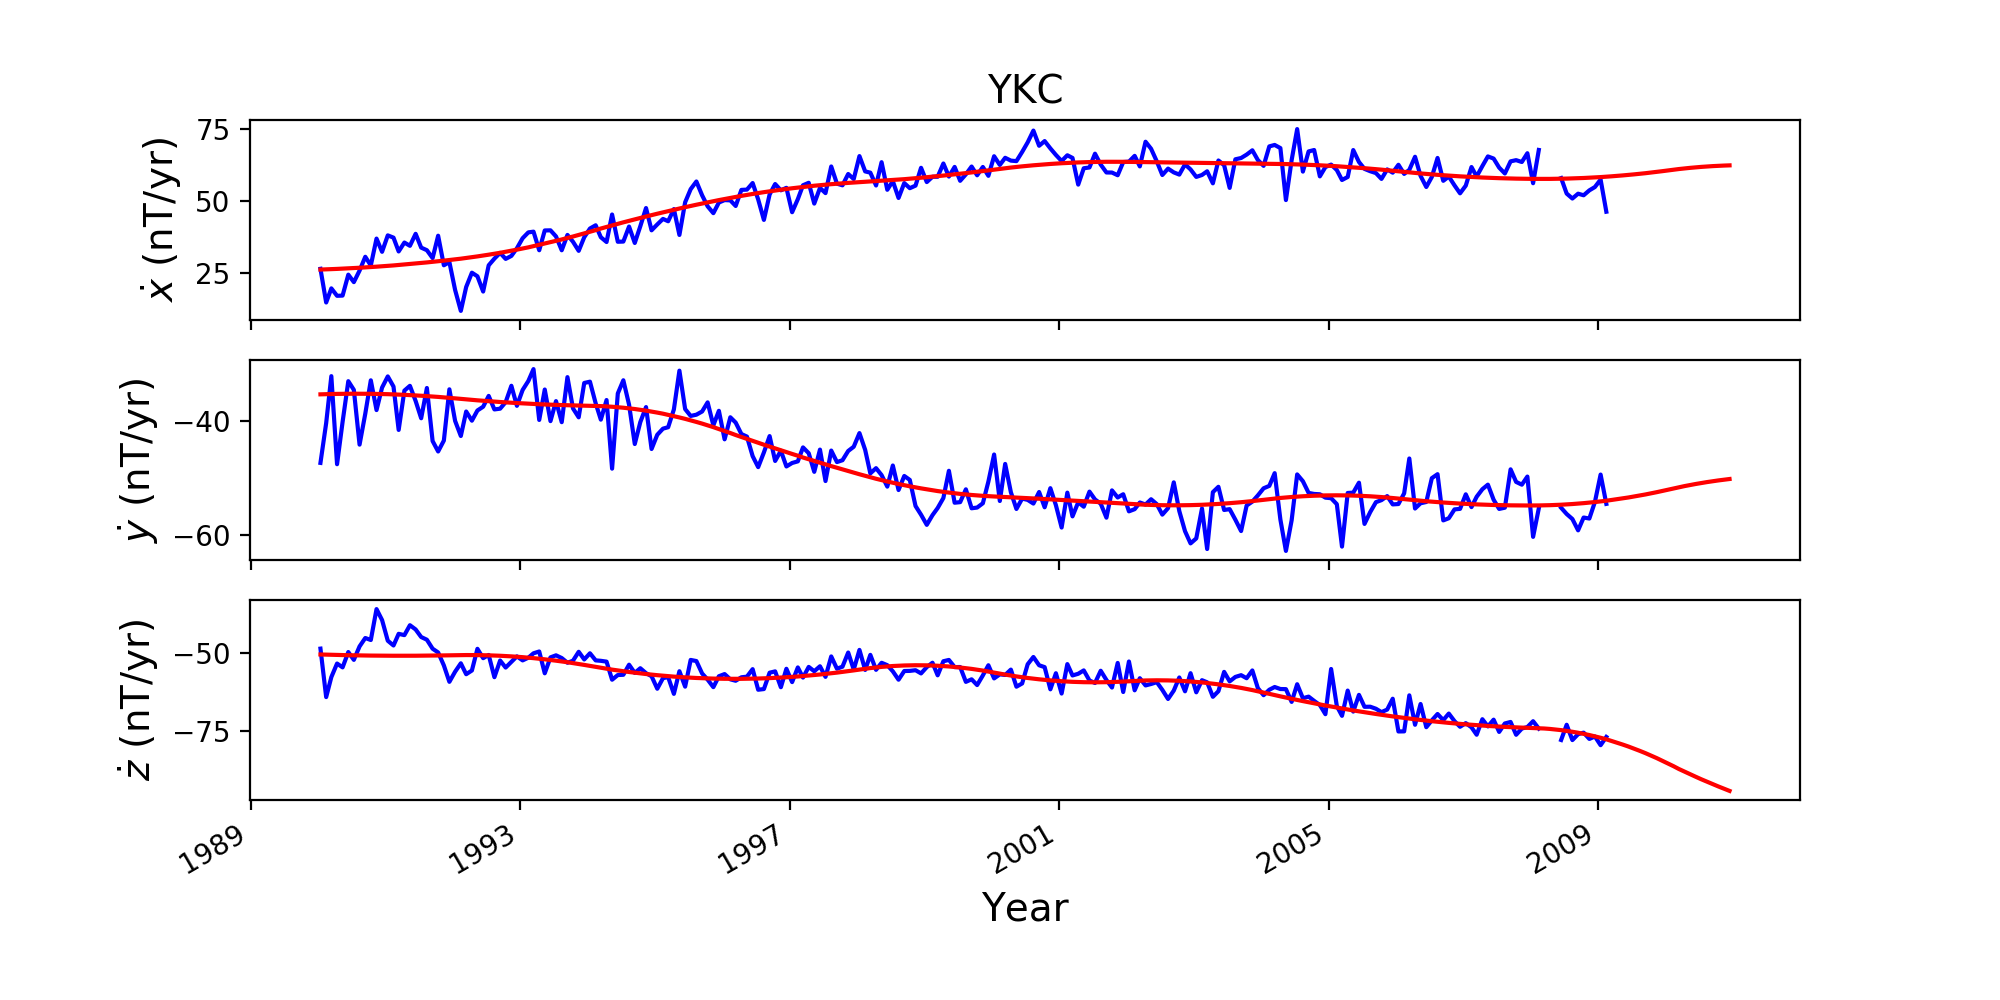

In [126]:
for observatory in observatory_list:
    svplots.plot_sv(dates=dates, sv=denoised.filter(regex=observatory), model=model_sv_data.filter(regex=observatory),
                    fig_size=(10, 5), font_size=10, label_size=14, plot_legend=False, obs=observatory, model_name='COV-OBS')

# Plot proxy signal, eigenvalues and eigenvectors

Compare the proxy signal used to denoise the data with the Dst index, measures the intensity of the equatorial electrojet (the "ring current"). Both signals are reduced to zero-mean and unit variance (z-score).

In [113]:
ae_file = '/Users/gracecox/Dropbox/ae_index/means/admm.csv'

/Users/gracecox/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


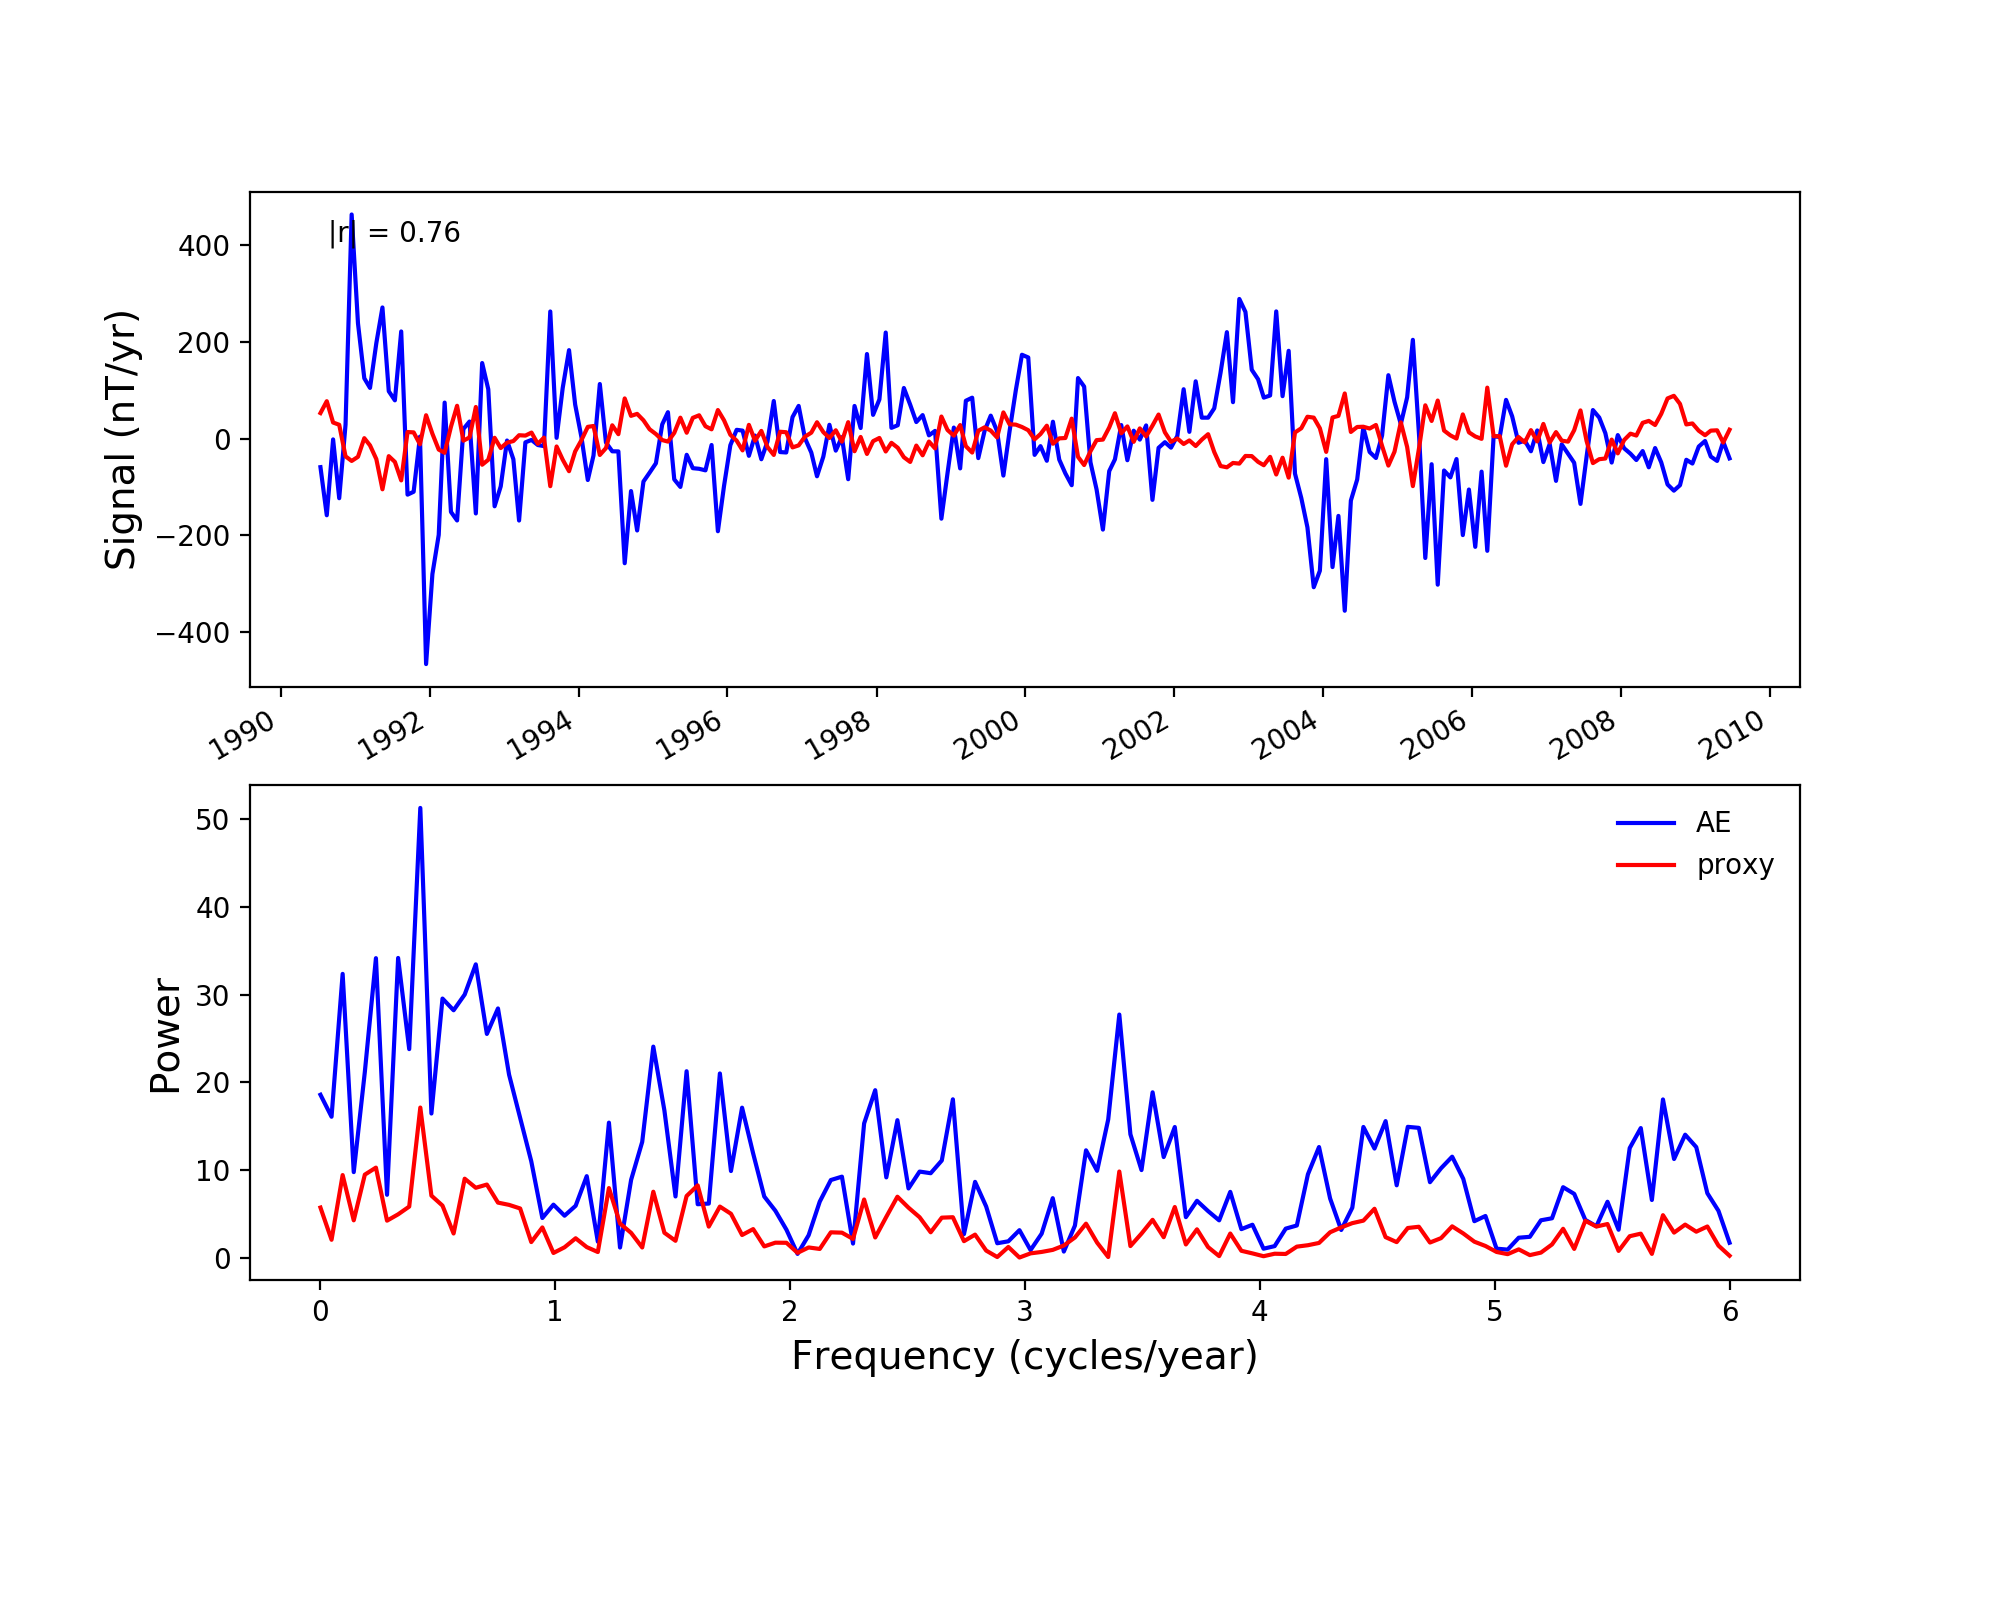

In [127]:
svplots.plot_index_dft(index_file=ae_file, dates=denoised.date, signal=proxy.astype('float'), fig_size=(10, 8), font_size=10,
                       label_size=14, plot_legend=True, index_name='AE')

Plot the eigenvalues of the covariance matrix of the residuals

/Users/gracecox/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


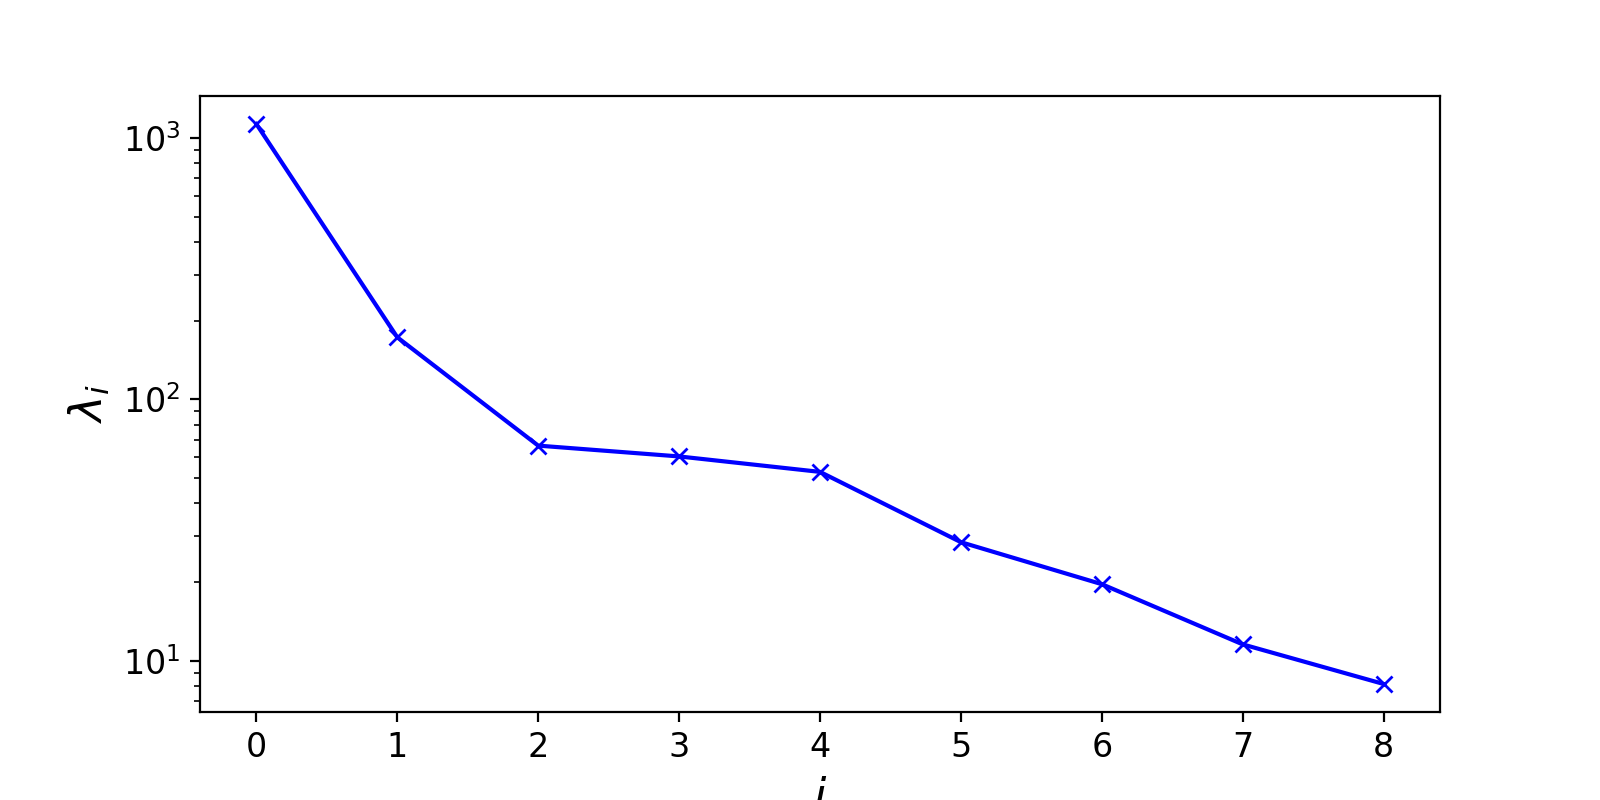

In [128]:
svplots.plot_eigenvalues(values=eigenvals, font_size=12, label_size=16, fig_size=(8, 4))

Plot the three eigenvectors corresponding to the largest eigenvalue. The noisiest direction (used to denoise in this example) is mostly:
Z in the polar region
 in auroral zone
 in the sub-auroral zone, similar to European observatories

/Users/gracecox/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


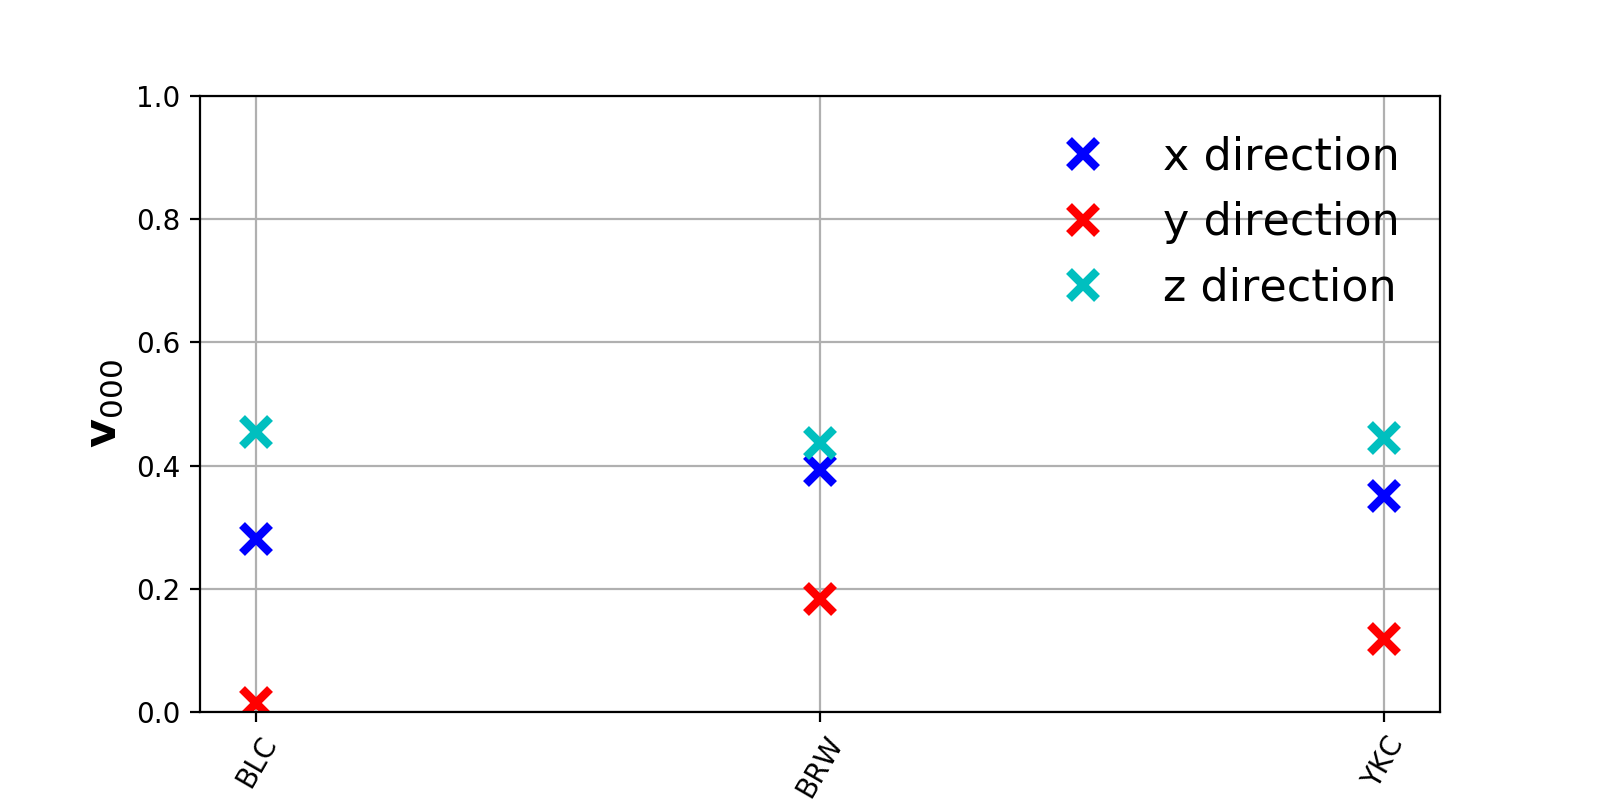

In [130]:
svplots.plot_eigenvectors(obs_names=observatory_list, eigenvecs=eigenvecs[:,0:1], fig_size=(8, 4),
                          font_size=10, label_size=16)

# Outlier detection

Remove remaining spikes in the time series.

In [ ]:
denoised.drop(['date'], axis=1, inplace=True)
for column in denoised:
    denoised[column] = denoise.detect_outliers(dates=dates, signal=denoised[column], obs_name=column, threshold=5,
                                               window_length=120, plot_fig=False, fig_size=(10, 3), font_size=10, label_size=14)
denoised.insert(0, 'date', dates)

# Write denoised data to file

In [ ]:
for observatory in observatory_list:
    print(observatory)
    sv_data=denoised.filter(regex=observatory)
    sv_data.insert(0, 'date', dates)
    sv_data.columns = ["date", "dX", "dY", "dZ"]
    inputoutput.write_csv_data(data=sv_data, write_path=download_dir + '/denoised/european/',
                               obs_name=observatory, decimal_dates=False)